# common

## functions.py

In [1]:
import numpy as np

def identity_function(x):
        return x

def step_function(x):
    return np.array(x > 0, dtype=np.int32)

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)

def relu(x):
    return np.maximum(0, x)

def relu_grad(x):
    grad = np.zeros(x)
    grad[x>=0] = 1
    return grad

def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T
    
    x = x - np.max(x) # 오버플로 대책
    return np.exp(x) / np.sum(np.exp(x))

def mean_squared_error(y, t):
    return 0.5 * np.sum((y-t)**2)

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    
    # 훈련 데이터가 원-핫 벡터라면 정답 레이블의 인덱스로 반환
    if t.size == y.size:
        t = t.argmax(axis=1)
        
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

def softmax_loss(X, t):
    y = softmax(X)
    return cross_entropy_error(y, t)

## gradient.py

In [2]:
import numpy as np

def _numerical_gradient_1d(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    for idx in range(x.size):
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val # 값 복원
        
    return grad


def numerical_gradient_2d(f, X):
    if X.ndim == 1:
        return _numerical_gradient_1d(f, X)
    else:
        grad = np.zeros_like(X)
        
        for idx, x in enumerate(X):
            grad[idx] = _numerical_gradient_1d(f, x)
        
        return grad


def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val # 값 복원
        it.iternext()   
        
    return grad

## layers.py

In [61]:
class Relu:
    def __init__(self):
        self.mask = None
        
    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0
        
        return out
    
    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout
        
        return dx
    
class Sigmoid:
    def __init__(self):
        self.out = None
        
    def forward(self, x):
        out = sigmoid(x)
        self.out = out
        return out
    
    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out
        
        return dx
    
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        
        self.x = None
        self.original_x_shape = None
        # 가중치와 편향 매개변수의 미분
        self.dW = None
        self.db = None
        
    def forward(self, x):
        # 텐서 대응
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x
        
        out = np.dot(self.x, self.W) + self.b
        
        return out
    
    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        dx = dx.reshape(*self.original_x_shape) # 입력 데이터 모양 변경(텐서 대응)
        return dx
    
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None # 손실함수
        self.y = None # softmax의 출력
        self.t = None # 정답 레이블(원-핫 인코딩 형태)
        
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss
    
    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size: # 정답 레이블이 원-핫 인코딩 형태일 때
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
            
        return dx
    
class Dropout:
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None
        
    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)
        
    def backward(self, dout):
        return dout * self.mask


class BatchNormalization:
    """
    http://arxiv.org/abs/1502.03167
    """
    def __init__(self, gamma, beta, momentum=0.9, running_mean=None, running_var=None):
        self.gamma = gamma
        self.beta = beta
        self.momentum = momentum
        self.input_shape = None # 합성곱 계층은 4차원, 완전연결 계층은 2차원  

        # 시험할 때 사용할 평균과 분산
        self.running_mean = running_mean
        self.running_var = running_var  
        
        # backward 시에 사용할 중간 데이터
        self.batch_size = None
        self.xc = None
        self.std = None
        self.dgamma = None
        self.dbeta = None

    def forward(self, x, train_flg=True):
        self.input_shape = x.shape
        if x.ndim != 2:
            N, C, H, W = x.shape
            x = x.reshape(N, -1)

        out = self.__forward(x, train_flg)
        
        return out.reshape(*self.input_shape)
            
    def __forward(self, x, train_flg):
        if self.running_mean is None:
            N, D = x.shape
            self.running_mean = np.zeros(D)
            self.running_var = np.zeros(D)
                        
        if train_flg:
            mu = x.mean(axis=0)
            xc = x - mu
            var = np.mean(xc**2, axis=0)
            std = np.sqrt(var + 10e-7)
            xn = xc / std
            
            self.batch_size = x.shape[0]
            self.xc = xc
            self.xn = xn
            self.std = std
            self.running_mean = self.momentum * self.running_mean + (1-self.momentum) * mu
            self.running_var = self.momentum * self.running_var + (1-self.momentum) * var            
        else:
            xc = x - self.running_mean
            xn = xc / ((np.sqrt(self.running_var + 10e-7)))
            
        out = self.gamma * xn + self.beta 
        return out

    def backward(self, dout):
        if dout.ndim != 2:
            N, C, H, W = dout.shape
            dout = dout.reshape(N, -1)

        dx = self.__backward(dout)

        dx = dx.reshape(*self.input_shape)
        return dx

    def __backward(self, dout):
        dbeta = dout.sum(axis=0)
        dgamma = np.sum(self.xn * dout, axis=0)
        dxn = self.gamma * dout
        dxc = dxn / self.std
        dstd = -np.sum((dxn * self.xc) / (self.std * self.std), axis=0)
        dvar = 0.5 * dstd / self.std
        dxc += (2.0 / self.batch_size) * self.xc * dvar
        dmu = np.sum(dxc, axis=0)
        dx = dxc - dmu / self.batch_size
        
        self.dgamma = dgamma
        self.dbeta = dbeta
        
        return dx
    
class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
        # 중간 데이터（backward 시 사용）
        self.x = None   
        self.col = None
        self.col_W = None
        
        # 가중치와 편향 매개변수의 기울기
        self.dW = None
        self.db = None

    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = 1 + int((H + 2*self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2*self.pad - FW) / self.stride)

        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T

        out = np.dot(col, col_W) + self.b
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        self.x = x
        self.col = col
        self.col_W = col_W

        return out

    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)

        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

        return dx


class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
        self.x = None
        self.arg_max = None

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)

        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)

        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x
        self.arg_max = arg_max

        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx

## multi_layer_net.py

In [4]:
import sys, os
sys.path.append(os.pardir) # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
from collections import OrderedDict

class MultiLayerNet:
    """완전연결 다층 신경망
    Parameters
    ----------
    input_size : 입력 크기（MNIST의 경우엔 784）
    hidden_size_list : 각 은닉층의 뉴런 수를 담은 리스트（e.g. [100, 100, 100]）
    output_size : 출력 크기（MNIST의 경우엔 10）
    activation : 활성화 함수 - 'relu' 혹은 'sigmoid'
    weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
        'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
        'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
    weight_decay_lambda : 가중치 감소(L2 법칙)의 세기
    """
    def __init__(self, input_size, hidden_size_list, output_size,
                 activation='relu', weight_init_std='relu', weight_decay_lambda=0):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size_list = hidden_size_list
        self.hidden_layer_num = len(hidden_size_list)
        self.weight_decay_lambda = weight_decay_lambda
        self.params = {}

        # 가중치 초기화
        self.__init_weight(weight_init_std)

        # 계층 생성
        activation_layer = {'sigmoid': Sigmoid, 'relu': Relu}
        self.layers = OrderedDict()
        for idx in range(1, self.hidden_layer_num+1):
            self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)],
                                                      self.params['b' + str(idx)])
            self.layers['Activation_function' + str(idx)] = activation_layer[activation]()

        idx = self.hidden_layer_num + 1
        self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)],
            self.params['b' + str(idx)])

        self.last_layer = SoftmaxWithLoss()

    def __init_weight(self, weight_init_std):
        """가중치 초기화
        
        Parameters
        ----------
        weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
            'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
            'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
        """
        all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]
        for idx in range(1, len(all_size_list)):
            scale = weight_init_std
            if str(weight_init_std).lower() in ('relu', 'he'):
                scale = np.sqrt(2.0 / all_size_list[idx - 1])  # ReLU를 사용할 때의 권장 초깃값
            elif str(weight_init_std).lower() in ('sigmoid', 'xavier'):
                scale = np.sqrt(1.0 / all_size_list[idx - 1])  # sigmoid를 사용할 때의 권장 초깃값
            self.params['W' + str(idx)] = scale * np.random.randn(all_size_list[idx-1], all_size_list[idx])
            self.params['b' + str(idx)] = np.zeros(all_size_list[idx])

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """손실 함수를 구한다.
        
        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블 
        
        Returns
        -------
        손실 함수의 값
        """
        y = self.predict(x)

        weight_decay = 0
        for idx in range(1, self.hidden_layer_num + 2):
            W = self.params['W' + str(idx)]
            weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W ** 2)

        return self.last_layer.forward(y, t) + weight_decay

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    def numerical_gradient(self, x, t):
        """기울기를 구한다(수치 미분).
        
        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        
        Returns
        -------
        각 층의 기울기를 담은 딕셔너리(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        loss_W = lambda W: self.loss(x, t)

        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = numerical_gradient(loss_W, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_W, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """기울기를 구한다(오차역전파법).
        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        
        Returns
        -------
        각 층의 기울기를 담은 딕셔너리(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = self.layers['Affine' + str(idx)].dW + self.weight_decay_lambda * self.layers['Affine' + str(idx)].W
            grads['b' + str(idx)] = self.layers['Affine' + str(idx)].db

        return grads

## multi_layer_net_extend.py

In [5]:
import sys, os
sys.path.append(os.pardir) # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
from collections import OrderedDict

class MultiLayerNetExtend:
    """완전 연결 다층 신경망(확장판)
    가중치 감소, 드롭아웃, 배치 정규화 구현
    Parameters
    ----------
    input_size : 입력 크기（MNIST의 경우엔 784）
    hidden_size_list : 각 은닉층의 뉴런 수를 담은 리스트（e.g. [100, 100, 100]）
    output_size : 출력 크기（MNIST의 경우엔 10）
    activation : 활성화 함수 - 'relu' 혹은 'sigmoid'
    weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
        'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
        'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
    weight_decay_lambda : 가중치 감소(L2 법칙)의 세기
    use_dropout : 드롭아웃 사용 여부
    dropout_ration : 드롭아웃 비율
    use_batchNorm : 배치 정규화 사용 여부
    """
    def __init__(self, input_size, hidden_size_list, output_size,
                 activation='relu', weight_init_std='relu', weight_decay_lambda=0, 
                 use_dropout = False, dropout_ration = 0.5, use_batchnorm=False):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size_list = hidden_size_list
        self.hidden_layer_num = len(hidden_size_list)
        self.use_dropout = use_dropout
        self.weight_decay_lambda = weight_decay_lambda
        self.use_batchnorm = use_batchnorm
        self.params = {}

        # 가중치 초기화
        self.__init_weight(weight_init_std)

        # 계층 생성
        activation_layer = {'sigmoid': Sigmoid, 'relu': Relu}
        self.layers = OrderedDict()
        for idx in range(1, self.hidden_layer_num+1):
            self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)],
                                                      self.params['b' + str(idx)])
            if self.use_batchnorm:
                self.params['gamma' + str(idx)] = np.ones(hidden_size_list[idx-1])
                self.params['beta' + str(idx)] = np.zeros(hidden_size_list[idx-1])
                self.layers['BatchNorm' + str(idx)] = BatchNormalization(self.params['gamma' + str(idx)], self.params['beta' + str(idx)])
                
            self.layers['Activation_function' + str(idx)] = activation_layer[activation]()
            
            if self.use_dropout:
                self.layers['Dropout' + str(idx)] = Dropout(dropout_ration)

        idx = self.hidden_layer_num + 1
        self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)], self.params['b' + str(idx)])

        self.last_layer = SoftmaxWithLoss()

    def __init_weight(self, weight_init_std):
        """가중치 초기화
        
        Parameters
        ----------
        weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
            'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
            'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
        """
        all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size]
        for idx in range(1, len(all_size_list)):
            scale = weight_init_std
            if str(weight_init_std).lower() in ('relu', 'he'):
                scale = np.sqrt(2.0 / all_size_list[idx - 1])  # ReLUを使う場合に推奨される初期値
            elif str(weight_init_std).lower() in ('sigmoid', 'xavier'):
                scale = np.sqrt(1.0 / all_size_list[idx - 1])  # sigmoidを使う場合に推奨される初期値
            self.params['W' + str(idx)] = scale * np.random.randn(all_size_list[idx-1], all_size_list[idx])
            self.params['b' + str(idx)] = np.zeros(all_size_list[idx])

    def predict(self, x, train_flg=False):
        for key, layer in self.layers.items():
            if "Dropout" in key or "BatchNorm" in key:
                x = layer.forward(x, train_flg)
            else:
                x = layer.forward(x)

        return x

    def loss(self, x, t, train_flg=False):
        """손실 함수를 구한다.
        
        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블 
        """
        y = self.predict(x, train_flg)

        weight_decay = 0
        for idx in range(1, self.hidden_layer_num + 2):
            W = self.params['W' + str(idx)]
            weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)

        return self.last_layer.forward(y, t) + weight_decay

    def accuracy(self, X, T):
        Y = self.predict(X, train_flg=False)
        Y = np.argmax(Y, axis=1)
        if T.ndim != 1 : T = np.argmax(T, axis=1)

        accuracy = np.sum(Y == T) / float(X.shape[0])
        return accuracy

    def numerical_gradient(self, X, T):
        """기울기를 구한다(수치 미분).
        
        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        
        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        loss_W = lambda W: self.loss(X, T, train_flg=True)

        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = numerical_gradient(loss_W, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_W, self.params['b' + str(idx)])
            
            if self.use_batchnorm and idx != self.hidden_layer_num+1:
                grads['gamma' + str(idx)] = numerical_gradient(loss_W, self.params['gamma' + str(idx)])
                grads['beta' + str(idx)] = numerical_gradient(loss_W, self.params['beta' + str(idx)])

        return grads
        
    def gradient(self, x, t):
        # forward
        self.loss(x, t, train_flg=True)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        for idx in range(1, self.hidden_layer_num+2):
            grads['W' + str(idx)] = self.layers['Affine' + str(idx)].dW + self.weight_decay_lambda * self.params['W' + str(idx)]
            grads['b' + str(idx)] = self.layers['Affine' + str(idx)].db

            if self.use_batchnorm and idx != self.hidden_layer_num+1:
                grads['gamma' + str(idx)] = self.layers['BatchNorm' + str(idx)].dgamma
                grads['beta' + str(idx)] = self.layers['BatchNorm' + str(idx)].dbeta

        return grads

## optimizer.py

In [6]:
import numpy as np

class SGD:
    
    """확률적 경사 하강법 (Stochastic Gradient Descent)"""
    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]
            
class Momentum:
    
    """모멘텀 SGD"""
    
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key]
            params[key] += self.v[key]
            
class Nesterov:
    
    """Nesterov's Accelerated Gradient"""
    # NAG는 모멘텀에서 한 단계 발전한 방법이다.
    
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.v[key] *= self.momentum
            self.v[key] -= self.lr * grads[key]
            params[key] += self.momentum * self.momentum * self.v[key]
            params[key] -= (1 + self.momentum) * self.lr * grads[key]
            
class AdaGrad:
    
    """AdaGrad"""
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)
            
class RMSprop:
    
    """RMSprop"""
    
    def __init__(self, lr=0.01, decay_rate=0.99):
        self.lr = lr
        self.decay_rate = decay_rate
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.h[key] *= self.decay_rate
            self.h[key] += (1 - self.decay_rate) * grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)
            
class Adam:
    
    """Adam"""
    
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
                
        self.iter += 1
        lr_t = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)
        
        for key in params.keys():
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)

## trainer.py

In [7]:
import sys, os
sys.path.append(os.pardir) # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np

class Trainer:
    """신경망 훈련을 대신 해주는 클래스
    """
    def __init__(self, network, x_train, t_train, x_test, t_test,
                 epochs=20, mini_batch_size=100,
                 optimizer='SGD', optimizer_param={'lr':0.01}, 
                 evaluate_sample_num_per_epoch=None, verbose=True):
        self.network = network
        self.verbose = verbose
        self.x_train = x_train
        self.t_train = t_train
        self.x_test = x_test
        self.t_test = t_test
        self.epochs = epochs
        self.batch_size = mini_batch_size
        self.evaluate_sample_num_per_epoch = evaluate_sample_num_per_epoch

        # optimzer
        optimizer_class_dict = {'sgd':SGD, 'momentum':Momentum, 'nesterov':Nesterov,
                                'adagrad':AdaGrad, 'rmsprpo':RMSprop, 'adam':Adam}
        self.optimizer = optimizer_class_dict[optimizer.lower()](**optimizer_param)
        
        self.train_size = x_train.shape[0]
        self.iter_per_epoch = max(self.train_size / mini_batch_size, 1)
        self.max_iter = int(epochs * self.iter_per_epoch)
        self.current_iter = 0
        self.current_epoch = 0
        
        self.train_loss_list = []
        self.train_acc_list = []
        self.test_acc_list = []

    def train_step(self):
        batch_mask = np.random.choice(self.train_size, self.batch_size)
        x_batch = self.x_train[batch_mask]
        t_batch = self.t_train[batch_mask]
        
        grads = self.network.gradient(x_batch, t_batch)
        self.optimizer.update(self.network.params, grads)
        
        loss = self.network.loss(x_batch, t_batch)
        self.train_loss_list.append(loss)
        if self.verbose: print("train loss:" + str(loss))
        
        if self.current_iter % self.iter_per_epoch == 0:
            self.current_epoch += 1
            
            x_train_sample, t_train_sample = self.x_train, self.t_train
            x_test_sample, t_test_sample = self.x_test, self.t_test
            if not self.evaluate_sample_num_per_epoch is None:
                t = self.evaluate_sample_num_per_epoch
                x_train_sample, t_train_sample = self.x_train[:t], self.t_train[:t]
                x_test_sample, t_test_sample = self.x_test[:t], self.t_test[:t]
                
            train_acc = self.network.accuracy(x_train_sample, t_train_sample)
            test_acc = self.network.accuracy(x_test_sample, t_test_sample)
            self.train_acc_list.append(train_acc)
            self.test_acc_list.append(test_acc)

            if self.verbose: print("=== epoch:" + str(self.current_epoch) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc) + " ===")
        self.current_iter += 1

    def train(self):
        for i in range(self.max_iter):
            self.train_step()

        test_acc = self.network.accuracy(self.x_test, self.t_test)

        if self.verbose:
            print("=============== Final Test Accuracy ===============")
            print("test acc:" + str(test_acc))     

## util.py

In [63]:
import numpy as np


def smooth_curve(x):
    """손실 함수의 그래프를 매끄럽게 하기 위해 사용
    
    참고：http://glowingpython.blogspot.jp/2012/02/convolution-with-numpy.html
    """
    window_len = 11
    s = np.r_[x[window_len-1:0:-1], x, x[-1:-window_len:-1]]
    w = np.kaiser(window_len, 2)
    y = np.convolve(w/w.sum(), s, mode='valid')
    return y[5:len(y)-5]


def shuffle_dataset(x, t):
    """데이터셋을 뒤섞는다.
    Parameters
    ----------
    x : 훈련 데이터
    t : 정답 레이블
    
    Returns
    -------
    x, t : 뒤섞은 훈련 데이터와 정답 레이블
    """
    permutation = np.random.permutation(x.shape[0])
    x = x[permutation,:] if x.ndim == 2 else x[permutation,:,:,:]
    t = t[permutation]

    return x, t

def conv_output_size(input_size, filter_size, stride=1, pad=0):
    return (input_size + 2*pad - filter_size) / stride + 1


def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """다수의 이미지를 입력받아 2차원 배열로 변환한다(평탄화).
    
    Parameters
    ----------
    input_data : 4차원 배열 형태의 입력 데이터(이미지 수, 채널 수, 높이, 너비)
    filter_h : 필터의 높이
    filter_w : 필터의 너비
    stride : 스트라이드
    pad : 패딩
    
    Returns
    -------
    col : 2차원 배열
    """
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col


def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    """(im2col과 반대) 2차원 배열을 입력받아 다수의 이미지 묶음으로 변환한다.
    
    Parameters
    ----------
    col : 2차원 배열(입력 데이터)
    input_shape : 원래 이미지 데이터의 형상（예：(10, 1, 28, 28)）
    filter_h : 필터의 높이
    filter_w : 필터의 너비
    stride : 스트라이드
    pad : 패딩
    
    Returns
    -------
    img : 변환된 이미지들
    """
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

# ch02

In [6]:
def AND(x1, x2):
    w1, w2, theta = 0.5, 0.5, 0.7
    tmp = x1*w1 + x2*w2
    if tmp <= theta:
        return 0
    elif tmp > theta:
        return 1
    
if __name__ == '__main__':
    for xs in [(0, 0), (0, 1), (1, 0), (1, 1)]:
        y = AND(xs[0], xs[1])
        print("AND" + str(xs) + " -> " + str(y))

AND(0, 0) -> 0
AND(0, 1) -> 0
AND(1, 0) -> 0
AND(1, 1) -> 1


In [7]:
import numpy as np
x = np.array([0, 1]) # 입력
w = np.array([0.5, 0.5]) # 가중치
b = -0.7
w*x

array([0. , 0.5])

In [8]:
np.sum(w*x)

0.5

In [9]:
np.sum(w*x) + b

-0.19999999999999996

In [11]:
np.dot(w, x) + b

-0.19999999999999996

## and_gate.py

In [3]:
import numpy as np

def AND(x1, x2):
    x = np.array([x1, x2])
    w = np.array([0.5, 0.5])
    b = -0.7
    tmp = np.sum(w*x) + b
    if tmp <= 0:
        return 0
    else:
        return 1
    
if __name__ == '__main__':
    for xs in [(0, 0), (0, 1), (1, 0), (1, 1)]:
        y = AND(xs[0], xs[1])
        print("AND" + str(xs) + " -> " + str(y))

AND(0, 0) -> 0
AND(0, 1) -> 0
AND(1, 0) -> 0
AND(1, 1) -> 1


## nand_gate.py

In [12]:
import numpy as np

def NAND(x1, x2):
    x = np.array([x1, x2])
    w = np.array([-0.5, -0.5])
    b = 0.7
    tmp = np.sum(w*x) + b
    if tmp <= 0:
        return 0
    else:
        return 1
    
if __name__ == '__main__':
    for xs in [(0, 0), (0, 1), (1, 0), (1, 1)]:
        y = NAND(xs[0], xs[1])
        print('NAND' + str(xs) + ' -> ' + str(y))

NAND(0, 0) -> 1
NAND(0, 1) -> 1
NAND(1, 0) -> 1
NAND(1, 1) -> 0


## or_gate.py

In [13]:
import numpy as np

def OR(x1, x2):
    x = np.array([x1, x2])
    w = np.array([0.5, 0.5])
    b = -0.2
    tmp = np.sum(w*x) + b
    if tmp <= 0:
        return 0
    else:
        return 1
    
if __name__ == '__main__':
    for xs in [(0, 0), (0, 1), (1, 0), (1, 1)]:
        y = OR(xs[0], xs[1])
        print('OR' + str(xs) + ' -> ' + str(y))

OR(0, 0) -> 0
OR(0, 1) -> 1
OR(1, 0) -> 1
OR(1, 1) -> 1


## xor_gate.py

In [14]:
def XOR(x1, x2):
    s1 = NAND(x1, x2)
    s2 = OR(x1, x2)
    y = AND(s1, s2)
    return y

if __name__ == '__main__':
    for xs in [(0, 0), (0, 1), (1, 0), (1, 1)]:
        y = XOR(xs[0], xs[1])
        print('XOR' + str(xs) + ' -> ' + str(y))

XOR(0, 0) -> 0
XOR(0, 1) -> 1
XOR(1, 0) -> 1
XOR(1, 1) -> 0


# ch03

In [15]:
def step_function(x):
    if x > 0:
        return 1
    else:
        return 0

In [24]:
def step_function(x):
    y = x > 0
    return y.astype(np.int32)

In [25]:
import numpy as np
x = np.array([-1.0, 1.0, 2.0])
x

array([-1.,  1.,  2.])

In [26]:
y = x > 0
y

array([False,  True,  True])

In [32]:
y = y.astype(np.int32)
y

array([0, 1, 1])

In [38]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [42]:
x = np.array([-1.0, 1.0, 2.0])
sigmoid(x)

array([0.26894142, 0.73105858, 0.88079708])

In [43]:
t = np.array([1.0, 2.0, 3.0])
1.0 + t

array([2., 3., 4.])

In [44]:
1.0 / t

array([1.        , 0.5       , 0.33333333])

In [68]:
def relu(x):
    return np.maximum(0, x)

In [79]:
import numpy as np
A = np.array([1, 2, 3, 4])
print(A)

[1 2 3 4]


In [80]:
np.ndim(A)

1

In [81]:
A.shape

(4,)

In [82]:
A.shape[0]

4

In [83]:
B = np.array([[1, 2], [3, 4], [5, 6]])
print(B)

[[1 2]
 [3 4]
 [5 6]]


In [84]:
np.ndim(B)

2

In [85]:
B.shape

(3, 2)

In [86]:
A = np.array([[1, 2], [3, 4]])
A.shape

(2, 2)

In [87]:
B = np.array([[5, 6], [7, 8]])
B.shape

(2, 2)

In [88]:
np.dot(A, B)

array([[19, 22],
       [43, 50]])

In [91]:
A = np.array([[1, 2, 3], [4, 5, 6]])
A.shape

(2, 3)

In [92]:
B = np.array([[1, 2], [3, 4], [5, 6]])
B.shape

(3, 2)

In [93]:
np.dot(A, B)

array([[22, 28],
       [49, 64]])

In [94]:
C = np.array([[1, 2], [3, 4]])
C.shape

(2, 2)

In [95]:
A.shape

(2, 3)

In [96]:
np.dot(A, C)

ValueError: shapes (2,3) and (2,2) not aligned: 3 (dim 1) != 2 (dim 0)

In [97]:
A = np.array([[1, 2], [3, 4], [5, 6]])
A.shape

(3, 2)

In [98]:
B = np.array([7, 8])
B.shape

(2,)

In [99]:
np.dot(A, B)

array([23, 53, 83])

In [100]:
X = np.array([1, 2])
X.shape

(2,)

In [101]:
W = np.array([[1, 3, 5], [2, 4, 6]])
print(W)

[[1 3 5]
 [2 4 6]]


In [102]:
W.shape

(2, 3)

In [104]:
Y = np.dot(X, W)
print(Y)

[ 5 11 17]


In [105]:
X = np.array([1.0, 0.5])
W1 = np.array([[0.1, 0.3, 0.5], [0.2, 0.4, 0.6]])
B1 = np.array([0.1, 0.2, 0.3])

print(W1.shape)
print(X.shape)
print(B1.shape)

(2, 3)
(2,)
(3,)


In [106]:
A1 = np.dot(X, W1) + B1

In [107]:
Z1 = sigmoid(A1)

print(A1)
print(Z1)

[0.3 0.7 1.1]
[0.57444252 0.66818777 0.75026011]


In [108]:
W2 = np.array([[0.1, 0.4], [0.2, 0.5], [0.3, 0.6]])
B2 = np.array([0.1, 0.2])

print(Z1.shape)
print(W2.shape)
print(B2.shape)

A2 = np.dot(Z1, W2) + B2
Z2 = sigmoid(A2)

(3,)
(3, 2)
(2,)


In [109]:
def identity_function(x):
    return x

W3 = np.array([[0.1, 0.3], [0.2, 0.4]])
B3 = np.array([0.1, 0.2])

A3 = np.dot(Z2, W3) + B3
Y = identity_function(A3)

In [110]:
print(A3)
print(Y)

[0.31682708 0.69627909]
[0.31682708 0.69627909]


In [111]:
def init_network():
    network = {}
    network['W1'] = np.array([[0.1, 0.3, 0.5], [0.2, 0.4, 0.6]])
    network['b1'] = np.array([0.1, 0.2, 0.3])
    network['W2'] = np.array([[0.1, 0.4], [0.2, 0.5], [0.3, 0.6]])
    network['b2'] = np.array([0.1, 0.2])
    network['W3'] = np.array([[0.1, 0.3], [0.2, 0.4]])
    network['b3'] = np.array([0.1, 0.2])
    
    return network

def forward(network, x):
    W1, W2, W3 = network['W1'], network['W2'], network['W3']
    b1, b2, b3 = network['b1'], network['b2'], network['b3']
    
    a1 = np.dot(x, W1) + b1
    z1 = sigmoid(a1)
    a2 = np.dot(z1, W2) + b2
    z2 = sigmoid(a2)
    a3 = np.dot(z2, W3) + b3
    y = identity_function(a3)
    
    return y

network = init_network()
x = np.array([1.0, 0.5])
y = forward(network, x)
print(y)

[0.31682708 0.69627909]


In [112]:
a = np.array([0.3, 2.9, 4.0])

exp_a = np.exp(a) # 지수 함수
print(exp_a)

[ 1.34985881 18.17414537 54.59815003]


In [113]:
sum_exp_a = np.sum(exp_a) # 지수 함수의 합
print(sum_exp_a)

74.1221542101633


In [114]:
y = exp_a / sum_exp_a
print(y)

[0.01821127 0.24519181 0.73659691]


In [115]:
def softmax(a):
    exp_a = np.exp(a)
    sum_exp_a = np.sum(exp_a)
    y = exp_a / sum_exp_a
    
    return y

In [116]:
a = np.array([1010, 1000, 990])
np.exp(a) / np.sum(np.exp(a)) # 소프트맥스 함수의 계산

C:\Users\Sangjin\AppData\Local\Temp\ipykernel_102068\608394385.py:2: RuntimeWarning: overflow encountered in exp
  np.exp(a) / np.sum(np.exp(a)) # 소프트맥스 함수의 계산
C:\Users\Sangjin\AppData\Local\Temp\ipykernel_102068\608394385.py:2: RuntimeWarning: invalid value encountered in true_divide
  np.exp(a) / np.sum(np.exp(a)) # 소프트맥스 함수의 계산


array([nan, nan, nan])

In [117]:
c = np.max(a) # c = 1010(최댓값)
a - c

array([  0, -10, -20])

In [118]:
np.exp(a - c) / np.sum(np.exp(a - c))

array([9.99954600e-01, 4.53978686e-05, 2.06106005e-09])

In [119]:
def softmax(a):
    c = np.max(a)
    exp_a = np.exp(a - c) # 오버플로 대책
    sum_exp_a = np.sum(exp_a)
    y = exp_a / sum_exp_a
    
    return y

In [120]:
a = np.array([0.3, 2.9, 4.0])
y = softmax(a)
print(y)

[0.01821127 0.24519181 0.73659691]


In [121]:
np.sum(y)

1.0

In [123]:
import sys, os
sys.path.append(os.pardir) # 부모 디렉터리의 파일을 가져올 수 있도록 설정
from mnist import load_mnist

# 처음 한 번은 몇 분 정도 걸립니다.
(x_train, t_train), (x_test, t_test) = \
    load_mnist(flatten=True, normalize=False)

# 각 데이터의 형상 출력
print(x_train.shape)
print(t_train.shape)
print(x_test.shape)
print(t_test.shape)

(60000, 784)
(60000,)
(10000, 784)
(10000,)


In [129]:
x, _ = get_data()
network = init_network()
W1, W2, W3 = network['W1'], network['W2'], network['W3']

x.shape

(10000, 784)

In [130]:
x[0].shape

(784,)

In [131]:
W1.shape

(784, 50)

In [132]:
W2.shape

(50, 100)

In [133]:
W3.shape

(100, 10)

In [136]:
list(range(0, 10))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [142]:
list(range(0, 10, 3))

[0, 3, 6, 9]

In [143]:
x = np.array([[0.1, 0.8, 0.1], [0.3, 0.1, 0.6],
              [0.2, 0.5, 0.3], [0.8, 0.1, 0.1]])
y = np.argmax(x, axis=1)
print(y)

[1 2 1 0]


In [144]:
y = np.array([1, 2, 1, 0])
t = np.array([1, 2, 0, 0])
print(y == t)
np.sum(y == t)

[ True  True False  True]


3

## step_function.py

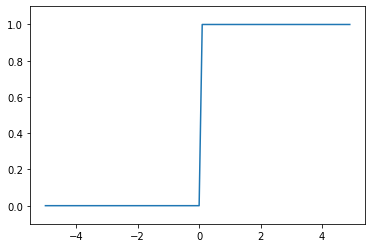

In [36]:
import numpy as np
import matplotlib.pyplot as plt

def step_function(x):
    return np.array(x > 0, dtype=np.int32)

X = np.arange(-5.0, 5.0, 0.1)
Y = step_function(X)
plt.plot(X, Y)
plt.ylim(-0.1, 1.1) # y축의 범위 지정
plt.show()

## sigmoid.py

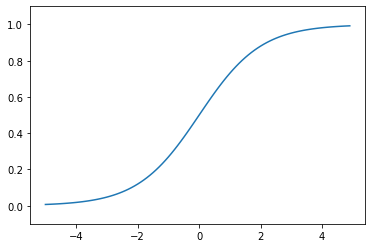

In [47]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

X = np.arange(-5.0, 5.0, 0.1)
Y = sigmoid(X)
plt.plot(X, Y)
plt.ylim(-0.1, 1.1)
plt.show()

## sig_step_compare.py

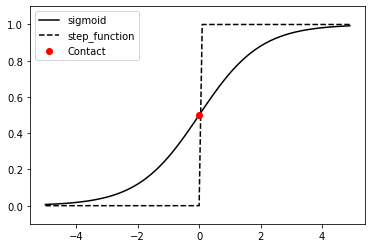

In [67]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def step_function(x):
    return np.array(x > 0, dtype=np.int32)

x = np.arange(-5.0, 5.0, 0.1)
y1 = sigmoid(x)
y2 = step_function(x)

plt.plot(x, y1, 'k-', label='sigmoid')
plt.plot(x, y2, 'k--', label='step_function')
plt.plot(0, 0.5, 'ro', label='Contact')
plt.ylim(-0.1, 1.1) # y축 범위 지정
plt.legend()
plt.show()

## relu.py

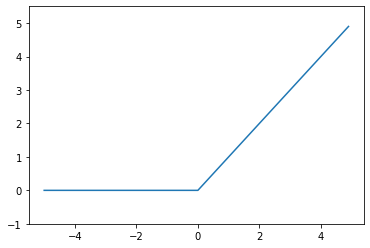

In [69]:
import numpy as np
import matplotlib.pyplot as plt

def relu(x):
    return np.maximum(0, x)

x = np.arange(-5.0, 5.0, 0.1)
y = relu(x)
plt.plot(x, y)
plt.ylim(-1.0, 5.5)
plt.show()

## mnist_show.py

In [125]:
import sys, os
sys.path.append(os.pardir) # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
from mnist import load_mnist
from PIL import Image

def img_show(img):
    pil_img = Image.fromarray(np.uint8(img))
    pil_img.show()
    
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=True, normalize=False)

img = x_train[0]
label = t_train[0]
print(label)

print(img.shape)
img = img.reshape(28, 28) # 형상을 원래 이미지의 크기로 변형
print(img.shape)

img_show(img)

5
(784,)
(28, 28)


## neuralnet_mnist.py

In [128]:
import sys, os
sys.path.append(os.pardir) # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import pickle
from mnist import load_mnist

def get_data():
    (x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, flatten=True, one_hot_label=False)
    return x_test, t_test

def init_network():
    with open("sample_weight.pkl", 'rb') as f:
        network = pickle.load(f)
    return network

def predict(network, x):
    W1, W2, W3 = network['W1'], network['W2'], network['W3']
    b1, b2, b3 = network['b1'], network['b2'], network['b3']
    
    a1 = np.dot(x, W1) + b1
    z1 = sigmoid(a1)
    a2 = np.dot(z1, W2) + b2
    z2 = sigmoid(a2)
    a3 = np.dot(z2, W3) + b3
    y = softmax(a3)
    
    return y

x, t = get_data()
network = init_network()
accuracy_cnt = 0
for i in range(len(x)):
    y = predict(network, x[i])
    p = np.argmax(y) # 확률이 가장 높은 원소의 인덱스를 얻는다.
    if p == t[i]:
        accuracy_cnt += 1
        
print("Accuracy:" + str(float(accuracy_cnt) / len(x)))

Accuracy:0.9352


## neuralnet_mnist_batch.py

In [135]:
import sys, os
sys.path.append(os.pardir) # 부모 디렉터리의 파일을 가져올 수 있도록
import numpy as np
import pickle
from mnist import load_mnist

def get_data():
    (x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, flatten=True, one_hot_label=False)
    return x_test, t_test

def init_network():
    with open("sample_weight.pkl", 'rb') as f:
        network = pickle.load(f)
    return network

def predict(network, x):
    W1, W2, W3 = network['W1'], network['W2'], network['W3']
    b1, b2, b3 = network['b1'], network['b2'], network['b3']
    
    a1 = np.dot(x, W1) + b1
    z1 = sigmoid(a1)
    a2 = np.dot(z1, W2) + b2
    z2 = sigmoid(a2)
    a3 = np.dot(z2, W3) + b3
    y = softmax(a3)
    
    return y

x, t = get_data()
network = init_network()

batch_size = 100 # 배치 크기
accuracy_cnt = 0

for i in range(0, len(x), batch_size):
    x_batch = x[i:i+batch_size]
    y_batch = predict(network, x_batch)
    p = np.argmax(y_batch, axis=1)
    accuracy_cnt += np.sum(p == t[i:i+batch_size])
    
print("Accuracy:" + str(float(accuracy_cnt) / len(x)))

Accuracy:0.9352


# ch04

In [1]:
y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]

In [5]:
def sum_squares_error(y, t):
    return 0.5 * np.sum((y-t)**2)

In [10]:
# 정답은 '2'
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]

# 예1: '2'일 확률이 가장 높다고 추정함(0.6)
y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]
sum_squares_error(np.array(y), np.array(t))

0.09750000000000003

In [11]:
# 예2: '7'일 확률이 가장 높다고 추정함(0.6)
y = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0]
sum_squares_error(np.array(y), np.array(t))

0.5975

In [12]:
def cross_entropy_error(y, t):
    delta = 1e-7
    return -np.sum(t * np.log(y + delta))

In [14]:
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]
cross_entropy_error(np.array(y), np.array(t))

0.510825457099338

In [15]:
y = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0]
cross_entropy_error(np.array(y), np.array(t))

2.302584092994546

In [20]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
from mnist import load_mnist

(x_train, t_train), (x_test, t_test) = \
    load_mnist(normalize=True, one_hot_label=True)

print(x_train.shape)
print(t_train.shape)

(60000, 784)
(60000, 10)


In [36]:
train_size = x_train.shape[0]
batch_size = 10
batch_mask = np.random.choice(train_size, batch_size)
x_batch = x_train[batch_mask]
t_batch = t_train[batch_mask]

In [42]:
np.random.choice(60000, 10)

array([ 7169, 37685, 29963, 46387,  3157, 39256, 43865, 57085, 49675,
        9167])

In [43]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    
    batch_size = y.shape[0]
    return -np.sum(t * np.log(y + 1e-7)) / batch_size

In [45]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] +1e-7)) / batch_size

In [46]:
# 나쁜 구현 예
def numerical_diff(f, x):
    h = 10e-50
    return (f(x + h) - f(x)) / h

In [47]:
np.float32(1e-50)

0.0

In [48]:
def numerical_diff(f, x):
    h = 1e-4 # 0.0001
    return (f(x+h) - f(x-h)) / (2*h)

In [49]:
def function_1(x):
    return 0.01*x**2 + 0.1*x

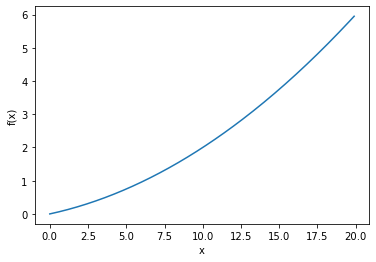

In [65]:
import numpy as np
import matplotlib.pyplot as plt

x = np.arange(0.0, 20.0, 0.1) # 0에서 20까지 0.1 간격의 배열 x를 만든다(단, 20은 미포함).
y = function_1(x)

plt.xlabel("x")
plt.ylabel("f(x)")
plt.plot(x, y)
plt.show()

In [66]:
numerical_diff(function_1, 5)

0.1999999999990898

In [67]:
numerical_diff(function_1, 10)

0.2999999999986347

In [84]:
def function_2(x):
    return x[0]**2 + x[1]**2
    # 또는 return np.sum(x**2)

In [93]:
def function_tmp1(x0):
    return x0*x0 + 4.0**2.0

numerical_diff(function_tmp1, 3.0)

6.00000000000378

In [94]:
def function_tmp2(x1):
    return 3.0**2.0 + x1*x1

numerical_diff(function_tmp2, 4.0)

7.999999999999119

In [111]:
def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x) # x와 형상이 같은 배열을 생성
    
    for idx in range(x.size):
        tmp_val = x[idx]
        # f(x+h) 계산
        x[idx] = tmp_val + h
        fxh1 = f(x)
        
        # f(x-h) 계산
        x[idx] = tmp_val - h
        fxh2 = f(x)
        
        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val # 값 복원
        
    return grad

In [112]:
numerical_gradient(function_2, np.array([3.0, 4.0]))

array([6., 8.])

In [113]:
numerical_gradient(function_2, np.array([0.0, 2.0]))

array([0., 4.])

In [114]:
numerical_gradient(function_2, np.array([3.0, 0.0]))

array([6., 0.])

In [133]:
def gradient_descent(f, init_x, lr=0.01, step_num=100):
    x = init_x
    
    for i in range(step_num):
        grad = numerical_gradient(f, x)
        x -= lr * grad
    return x

In [134]:
def function_2(x):
    return x[0]**2 + x[1]**2

init_x = np.array([-3.0, 4.0])
gradient_descent(function_2, init_x=init_x, lr=0.1, step_num=100)

array([-6.11110793e-10,  8.14814391e-10])

[-2.58983747e+13 -1.29524862e+12]


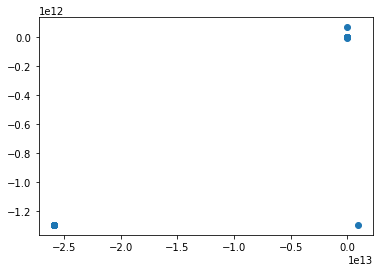

In [145]:
# 학습률이 너무 큰 예: lr=10.0
init_x = np.array([-3.0, 4.0])
x, x_history = gradient_descent(function_2, init_x=init_x, lr=10.0, step_num=100)

print(x)
plt.plot(x_history[:, 0], x_history[:, 1], 'o')
plt.show()

[-2.99999994  3.99999992]


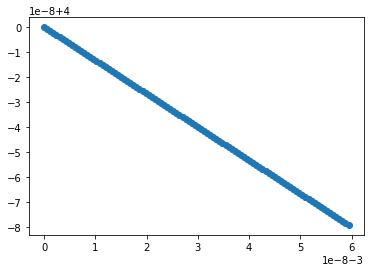

In [147]:
# 학습률이 너무 작은 예: lr=1e-10
init_x = np.array([-3.0, 4.0])
x, x_history = gradient_descent(function_2, init_x=init_x, lr=1e-10, step_num=100)

print(x)
plt.plot(x_history[:, 0], x_history[:, 1], 'o')
plt.show()

In [163]:
import sys, os
sys.path.append(os.pardir)
import numpy as np

class simpleNet():
    def __init__(self):
        self.W = np.random.randn(2, 3) # 정규분포로 초기화
        
    def predict(self, x):
        return np.dot(x, self.W)
    
    def loss(self, x, t):
        z = self.predict(x)
        y = softmax(z)
        loss = cross_entropy_error(y, t)
        
        return loss

In [164]:
net = simpleNet()
print(net.W) # 가중치 매개변수

[[ 1.23208315  0.7533233   0.78894051]
 [ 1.69772377  0.23329618 -0.28527909]]


In [165]:
x = np.array([0.6, 0.9])
p = net.predict(x)
print(p)

[2.26720128 0.66196054 0.21661313]


In [166]:
np.argmax(p)

0

In [167]:
t = np.array([0, 0, 1]) # 정답 레이블
net.loss(x, t)

2.3353903561752882

In [170]:
def f(W):
    return net.loss(x, t)

dW = numerical_gradient(f, net.W)
print(dW)

[[ 0.09791527  0.3711632  -0.46907847]
 [ 0.1468729   0.55674481 -0.70361771]]


In [172]:
f = lambda w: net.loss(x, t)
dW = numerical_gradient(f, net.W)
print(dW)

[[ 0.09791527  0.3711632  -0.46907847]
 [ 0.1468729   0.55674481 -0.70361771]]


In [177]:
net = TwoLayerNet(input_size=784, hidden_size=100, output_size=10)
print(net.params['W1'].shape)
print(net.params['b1'].shape)
print(net.params['W2'].shape)
print(net.params['b2'].shape)

(784, 100)
(100,)
(100, 10)
(10,)


In [178]:
x = np.random.rand(100, 784) # 더미 입력 데이터(100장 분량)
y = net.predict(x)

In [180]:
x = np.random.rand(100, 784) # 더미 입력 데이터(100장 분량)
t = np.random.rand(100, 10) # 더미 정답 레이블(100장 분량)

grads = net.numerical_gradient(x, t) # 기울기 계산

print(grads['W1'].shape)
print(grads['b1'].shape)
print(grads['W2'].shape)
print(grads['b2'].shape)

(784, 100)
(100,)
(100, 10)
(10,)


## gradient_1d.py

0.1999999999990898


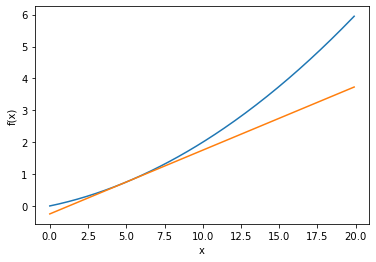

In [70]:
import numpy as np
import matplotlib.pyplot as plt

def numerical_diff(f, x):
    h = 1e-4 # 0.0001
    return (f(x+h) - f(x-h)) / (2*h)

def function_1(x):
    return 0.01*x**2 + 0.1*x

def tangent_line(f, x):
    d = numerical_diff(f, x)
    print(d)
    y = f(x) - d*x
    return lambda t: d*t + y

x = np.arange(0.0, 20.0, 0.1)
y = function_1(x)
plt.xlabel("x")
plt.ylabel("f(x)")

tf = tangent_line(function_1, 5)
y2 = tf(x)

plt.plot(x, y)
plt.plot(x, y2)
plt.show()

## gradient_2d.py

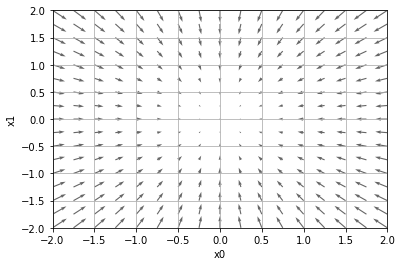

In [132]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def _numerical_gradient_no_batch(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x) # x와 형상이 같은 배열을 생성
    
    for idx in range(x.size):
        tmp_val = x[idx]
        
        # f(x+h) 계산
        x[idx] = float(tmp_val) + h
        fxh1 = f(x)
        
        # f(x-h) 계산
        x[idx] = float(tmp_val) - h
        fxh2 = f(x)
        
        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val #  값 복원
        
    return grad

def numerical_gradient(f, X):
    if X.ndim == 1:
        return _numerical_gradient_no_batch(f, X)
    else:
        grad = np.zeros_like(X)
        
        for idx, x in enumerate(X):
            grad[idx] = _numerical_gradient_no_batch(f, x)
            
        return grad
    
def function_2(x):
    if x.ndim == 1:
        return np.sum(x**2)
    else:
        return np.sum(x**2, axis=1)
    
def tangent_line(f, x):
    d = numerical_gradient(f, x)
    print(d)
    y = f(x) - d*x
    return lambda t: d*t + y

if __name__ == '__main__':
    x0 = np.arange(-2, 2.5, 0.25)
    x1 = np.arange(-2, 2.5, 0.25)
    X, Y = np.meshgrid(x0, x1)
    
    X = X.flatten()
    Y = Y.flatten()
    
    grad = numerical_gradient(function_2, np.array([X, Y]))
    
    plt.figure()
    plt.quiver(X, Y, -grad[0], -grad[1], angles="xy", color="#666666")#, headwidth=10, scale=40, color="#444444"
    plt.xlim([-2, 2])
    plt.ylim([-2, 2])
    plt.xlabel("x0")
    plt.ylabel("x1")
    plt.grid()
    plt.draw()
    plt.show()

## gradient_method.py

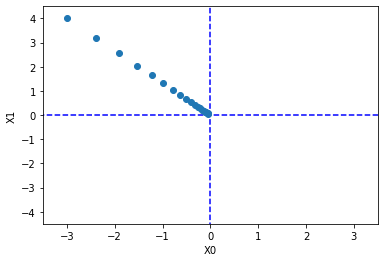

In [139]:
import numpy as np
import matplotlib.pyplot as plt

def gradient_descent(f, init_x, lr=0.01, step_num=100):
    x = init_x
    x_history = []
    
    for i in range(step_num):
        x_history.append(x.copy())
        
        grad = numerical_gradient(f, x)
        x -= lr * grad
        
    return x, np.array(x_history)

def function_2(x):
    return x[0]**2 + x[1]**2

init_x = np.array([-3.0, 4.0])

lr = 0.1
step_num = 20
x, x_history = gradient_descent(function_2, init_x, lr=lr, step_num=step_num)

plt.plot([-5, 5], [0, 0], '--b')
plt.plot([0, 0], [-5, 5], '--b')
plt.plot(x_history[:, 0], x_history[:, 1], 'o')

plt.xlim(-3.5, 3.5)
plt.ylim(-4.5, 4.5)
plt.xlabel("X0")
plt.ylabel("X1")
plt.show()

## gradient_simplenet.py

In [168]:
import sys, os
sys.path.append(os.pardir)
import numpy as np

class simpleNet:
    def __init__(self):
        self.W = np.random.randn(2, 3) # 정규분포로 초기화
        
    def predict(self, x):
        return np.dot(x, self.W)
    
    def loss(self, x, t):
        z = self.predict(x)
        y = softmax(z)
        loss = cross_entropy_error(y, t)
        
        return loss
    
x = np.array([0.6, 0.9])
t = np.array([0, 0, 1])

net = simpleNet()

f = lambda w: net.loss(x, t)
dW = numerical_gradient(f, net.W)

print(dW)

[[ 0.09791527  0.3711632  -0.46907847]
 [ 0.1468729   0.55674481 -0.70361771]]


## two_layer_net.py

In [175]:
import sys, os
sys.path.append(os.pardir) # 부모 디렉터리의 파일을 가져올 수 있도록 설정

class TwoLayerNet:
    
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
        
    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
    
    # x: 입력 데이터, t: 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
    
    # x: 입력 데이터, t: 정답 레이블
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
    
    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        da1 = np.dot(dy, W2.T)
        dz1 = sigmoid_grad(a1) * da1
        grads['W1'] = np.dot(x.T, dz1)
        grads['b1'] = np.sum(dz1, axis=0)
        
        return grads

## train_neuralnet.py

train acc, test acc | 0.09863333333333334, 0.0958
train acc, test acc | 0.79005, 0.7995
train acc, test acc | 0.87905, 0.8828
train acc, test acc | 0.8992666666666667, 0.9027
train acc, test acc | 0.9076666666666666, 0.9129
train acc, test acc | 0.91355, 0.9161
train acc, test acc | 0.9182166666666667, 0.9207
train acc, test acc | 0.9231166666666667, 0.9253
train acc, test acc | 0.9267666666666666, 0.9259
train acc, test acc | 0.9304333333333333, 0.9301
train acc, test acc | 0.9330833333333334, 0.9327
train acc, test acc | 0.93525, 0.9347
train acc, test acc | 0.9374333333333333, 0.9366
train acc, test acc | 0.9402, 0.9384
train acc, test acc | 0.9429833333333333, 0.9409
train acc, test acc | 0.9445666666666667, 0.9423
train acc, test acc | 0.9466, 0.944


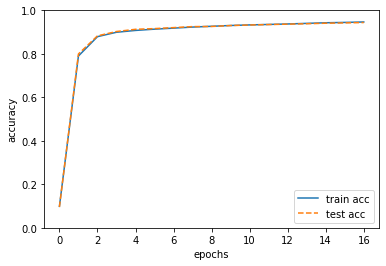

In [188]:
import sys, os
sys.path.append(os.pardir) # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from mnist import load_mnist

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

# 하이퍼파라미터
iters_num = 10000 # 반복 횟수를 적절히 설정한다.
train_size = x_train.shape[0]
batch_size = 100 # 미니배치 크기
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 기울기 계산
    # grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    
    # 매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
        
    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    # 1에폭당 정확도 계산
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))
        
# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

# ch05

In [6]:
x = np.array([[1.0, -0.5], [-2.0, 3.0]])
print(x)

[[ 1.  -0.5]
 [-2.   3. ]]


In [7]:
mask = (x <= 0)
print(mask)

[[False  True]
 [ True False]]


In [8]:
print(x[mask])
x[mask] = 0
print(x)

[-0.5 -2. ]
[[1. 0.]
 [0. 3.]]


In [12]:
X = np.random.rand(2) # 입력
W = np.random.rand(2, 3) # 가중치
B = np.random.rand(3) # 편향

print(X.shape)
print(W.shape)
print(B.shape)

Y = np.dot(X, W) + B

print(Y.shape)

(2,)
(2, 3)
(3,)
(3,)


In [17]:
print(np.dot(B, W.T))

[0.79055296 0.94863597]


In [18]:
print(np.dot(W, B))

[0.79055296 0.94863597]


In [19]:
X_dot_W = np.array([[0, 0, 0], [10, 10, 10]])
B = np.array([1, 2, 3])

X_dot_W

array([[ 0,  0,  0],
       [10, 10, 10]])

In [20]:
X_dot_W + B

array([[ 1,  2,  3],
       [11, 12, 13]])

In [21]:
dY = np.array([[1, 2, 3], [4, 5, 6]])
dY

array([[1, 2, 3],
       [4, 5, 6]])

In [22]:
dB = np.sum(dY, axis=0)
dB

array([5, 7, 9])

In [23]:
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.db = None
        
    def forward(self, x):
        self.x = x
        out = np.dot(x, self.W) + self.b
        
        return out
    
    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        return dx

## layer_naive.py

In [3]:
class MulLayer:
    def __init__(self):
        self.x = None
        self.y = None
    
    def forward(self, x, y):
        self.x = x
        self.y = y
        out = x * y
        
        return out
    
    def backward(self, dout):
        dx = dout * self.y # x와 y를 바꾼다.
        dy = dout * self.x
        
        return dx, dy
    
class AddLayer():
    def __init__(self):
        pass
    
    def forward(self, x, y):
        out = x + y
        
        return out
    
    def backward(self, dout):
        dx = dout * 1
        dy = dout * 1
        
        return dx, dy

## buy_apple.py

In [2]:
apple = 100
apple_num = 2
tax = 1.1

mul_apple_layer = MulLayer()
mul_tax_layer = MulLayer()

# forward
apple_price = mul_apple_layer.forward(apple, apple_num)
price = mul_tax_layer.forward(apple_price, tax)

# backward
dprice = 1
dapple_price, dtax = mul_tax_layer.backward(dprice)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)

print("price:", int(price))
print("dApple:", dapple)
print("dApple_num:", int(dapple_num))
print("dTax:", dtax)

price: 220
dApple: 2.2
dApple_num: 110
dTax: 200


## buy_apple_orange.py

In [4]:
apple = 100
apple_num = 2
orange = 150
orange_num = 3
tax = 1.1

# layer
mul_apple_layer = MulLayer()
mul_orange_layer = MulLayer()
add_apple_orange_layer = AddLayer()
mul_tax_layer = MulLayer()

# forward
apple_price = mul_apple_layer.forward(apple, apple_num)
orange_price = mul_orange_layer.forward(orange, orange_num)
all_price = add_apple_orange_layer.forward(apple_price, orange_price)
price = mul_tax_layer.forward(all_price, tax)

# backward
dprice = 1
dall_price, dtax = mul_tax_layer.backward(dprice)
dapple_price, dorange_price = add_apple_orange_layer.backward(dall_price)
dorange, dorange_num = mul_orange_layer.backward(dorange_price)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)

print("price:", int(price))
print("dApple:", dapple)
print("dApple_num:", int(dapple_num))
print("dOrange:", dorange)
print("dOrange_num:", int(dorange_num))
print("dTax:", dtax)

price: 715
dApple: 2.2
dApple_num: 110
dOrange: 3.3000000000000003
dOrange_num: 165
dTax: 650


## two_layer_net.py

In [37]:
import sys, os
sys.path.append(os.pardir) # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
from collections import OrderedDict

class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size) 
        self.params['b2'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])

        self.lastLayer = SoftmaxWithLoss()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        
        return x
        
    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x : 입력 데이터, t : 정답 레이블
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads

## gradient_chech.py 

In [39]:
import sys, os
sys.path.append(os.pardir) # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
from mnist import load_mnist

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

x_batch = x_train[:3]
t_batch = t_train[:3]

grad_numerical = network.numerical_gradient(x_batch, t_batch)
grad_backprop = network.gradient(x_batch, t_batch)

# 각 가중치의 절대 오차의 평균을 구한다.
for key in grad_numerical.keys():
    diff = np.average(np.abs(grad_backprop[key] - grad_numerical[key]))
    print(key + ":" + str(diff))

W1:3.4495047343489376e-10
b1:2.0934772587460818e-09
W2:5.2765279127798105e-09
b2:1.3956062000219925e-07


## train_neuralnet.py

In [42]:
import sys, os
sys.path.append(os.pardir)

import numpy as np
from mnist import load_mnist

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 기울기 계산
    # grad = network.numerical_gradient(x_batch, t_batch) # 수치 미분 방식
    grad = network.gradient(x_batch, t_batch) # 오차역전파법 방식(훨씬 빠르다)
    
    # 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
        
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)`
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(train_acc, test_acc)

0.10673333333333333 0.1034
0.9030166666666667 0.9052
0.9199 0.9224
0.93265 0.9319
0.9422 0.9404
0.9511833333333334 0.9462
0.95555 0.9513
0.9588 0.9543
0.9622666666666667 0.9571
0.9654166666666667 0.9603
0.9676 0.9614
0.9709666666666666 0.9643
0.97255 0.965
0.9732333333333333 0.9657
0.9745666666666667 0.9667
0.9774666666666667 0.9692
0.9775333333333334 0.9686


# ch06

In [14]:
from mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 훈련 데이터를 뒤섞는다.
x_train, t_train = shuffle_dataset(x_train, t_train)

# 20%를 검증 데이터로 분할
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)

x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]

In [25]:
weight_decay = 10 ** np.random.uniform(-8, -4)
lr = 10 ** np.random.uniform(-6, -2)

## optimizer_compare_naive.py

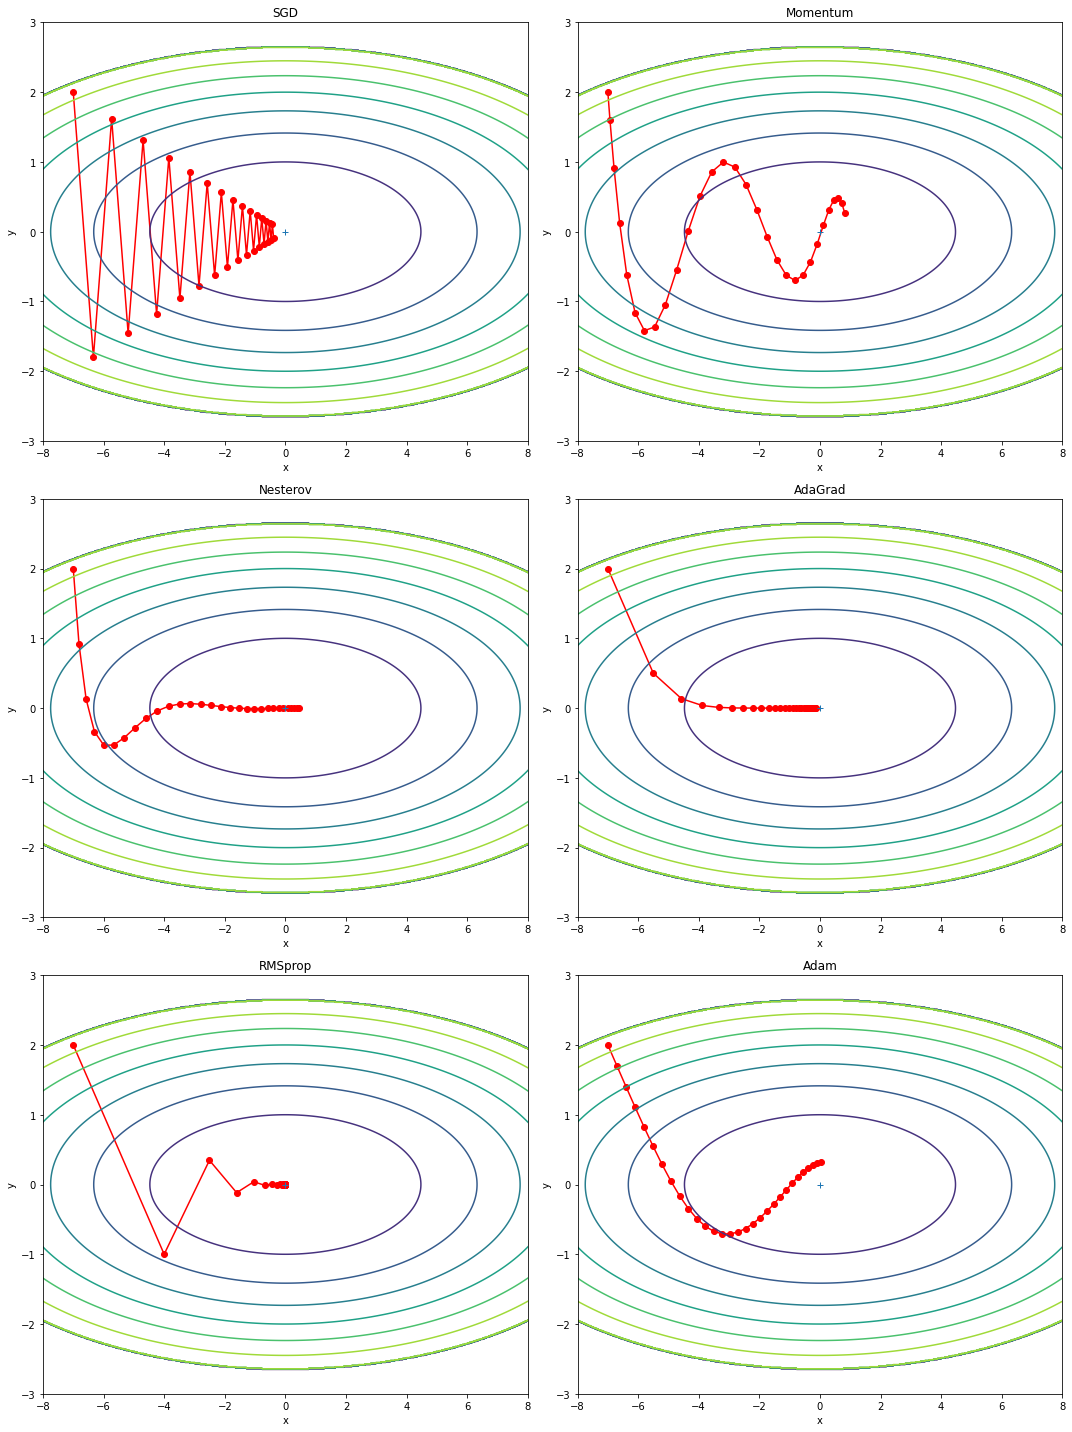

In [44]:
import sys, os
sys.path.append(os.pardir) # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

def f(x, y):
    return x**2 / 20.0 + y**2

def df(x, y):
    return x / 10.0, 2.0*y

init_pos = (-7.0, 2.0)
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0

optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.95)
optimizers["Momentum"] = Momentum(lr=0.1)
optimizers["Nesterov"] = Nesterov(lr=0.1)
optimizers["AdaGrad"] = AdaGrad(lr=1.5)
optimizers["RMSprop"] = RMSprop(lr=0.3)
optimizers["Adam"] = Adam(lr=0.3)

idx = 1
plt.figure(figsize=(15, 20))

for key in optimizers:
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]
    
    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])
        
        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)
        
    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)
    
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    
    # 외곽선 단순화
    mask = Z > 7
    Z[mask] = 0
    
    # 그래프 그리기
    plt.subplot(3, 2, idx)
    idx += 1
    plt.plot(x_history, y_history, 'o-', color='red')
    plt.contour(X, Y, Z)
    plt.ylim(-3, 3)
    plt.xlim(-8, 8)
    plt.plot(0, 0, '+')
    plt.title(key)
    plt.xlabel("x")
    plt.ylabel("y")

plt.tight_layout()
plt.show()

## optimizer_compare_mnist.py

===========iteration:0===========
SGD:2.4365572505552304
Momentum:2.3205879091287676
Nesterov:2.29605375769932
AdaGrad:2.0577782664115105
RMSprop:12.269085114962188
Adam:2.15852230283355
===========iteration:100===========
SGD:1.704550838294661
Momentum:0.35654760527907536
Nesterov:0.28446437654492684
AdaGrad:0.12252091001181173
RMSprop:0.23425844170800364
Adam:0.2810357329685007
===========iteration:200===========
SGD:0.819842492698688
Momentum:0.22834726798417282
Nesterov:0.17955024658072666
AdaGrad:0.08477377999090738
RMSprop:0.12242199184799347
Adam:0.12929010607389405
===========iteration:300===========
SGD:0.5325858154804451
Momentum:0.2095493193682869
Nesterov:0.12371266125918283
AdaGrad:0.08050736575538892
RMSprop:0.0918250635012072
Adam:0.11224056543435199
===========iteration:400===========
SGD:0.45139386134421133
Momentum:0.1980860577379055
Nesterov:0.13877801852015725
AdaGrad:0.08247972002051186
RMSprop:0.11292685443219573
Adam:0.0999707687502611
===========iteration:500===

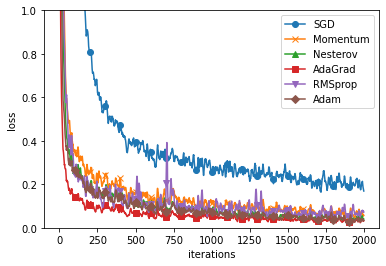

In [58]:
import sys, os
sys.path.append(os.pardir) # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import matplotlib.pyplot as plt
from mnist import load_mnist

# 0. MNIST 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000

# 1. 실험용 설정
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['Nesterov'] = Nesterov()
optimizers['AdaGrad'] = AdaGrad()
optimizers['RMSprop'] = RMSprop()
optimizers['Adam'] = Adam()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []
    
# 2. 훈련 시작
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
        
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
        
    if i % 100 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))
            
# 3. 그래프 그리기
markers = {"SGD": "o", "Momentum": "x", "Nesterov": "^", "AdaGrad": "s", "RMSprop": "v", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

## weight_init_activation_histogram.py

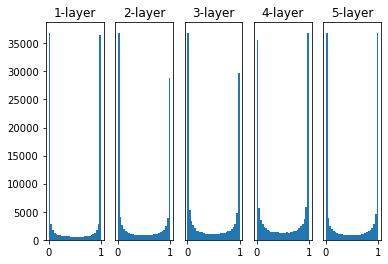

In [63]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def ReLU(x):
    return np.maximum(0, x)

def tanh(x):
    return np.tanh(x)

input_data = np.random.randn(1000, 100) # 1000개의 데이터
node_num = 100 # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5 # 은닉층이 5개
activations = {} # 이곳에 활성화 결과를 저장

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
        
    w = np.random.randn(node_num, node_num) * 1
    a = np.dot(x, w)    
    z = sigmoid(a)
    activations[i] = z
    
# 히스토그램 그리기
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    plt.hist(a.flatten(), 30, range=(0, 1))
plt.show()

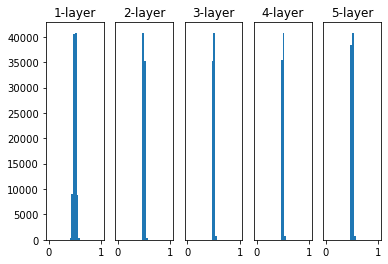

In [68]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def ReLU(x):
    return np.maximum(0, x)

def tanh(x):
    return np.tanh(x)

input_data = np.random.randn(1000, 100)
node_num = 100
hidden_layer_size = 5
activations = {}

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
        
    w = np.random.randn(node_num, node_num) * 0.01
    a = np.dot(x, w)
    z = sigmoid(a)
    activations[i] = z
    
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    plt.hist(a.flatten(), 30, range=(0, 1))
plt.show()

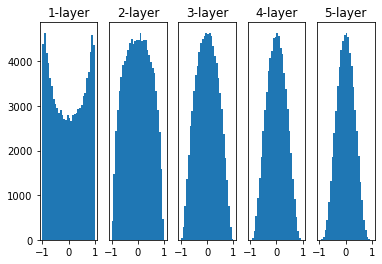

In [74]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def ReLU(x):
    return np.maximum(0, x)

def tanh(x):
    return np.tanh(x)

input_data = np.random.randn(1000, 100)
node_num = 100
hidden_layer_size = 5
activations = {}

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
        
    w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)
    a = np.dot(x, w)
    z = tanh(a)
    activations[i] = z
    
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    plt.hist(a.flatten(), 30, range=(-1, 1))
plt.show()

## weight_init_compare.py

===========iteration:0===========
std=0.01:2.302515663605467
Xavier:2.3130927276133724
He:2.270016949077702
===========iteration:100===========
std=0.01:2.3016793819324155
Xavier:2.2382440698495034
He:1.7078029558522696
===========iteration:200===========
std=0.01:2.3035172574371154
Xavier:2.1365171619789614
He:0.9630597319790024
===========iteration:300===========
std=0.01:2.302430611342297
Xavier:1.8120516137596239
He:0.7151120149818212
===========iteration:400===========
std=0.01:2.302929940425075
Xavier:1.2156496803097767
He:0.5344586637363877
===========iteration:500===========
std=0.01:2.2998090152348833
Xavier:0.740790266586417
He:0.3501527656025222
===========iteration:600===========
std=0.01:2.3013229556694794
Xavier:0.6355201167753279
He:0.4058839033252105
===========iteration:700===========
std=0.01:2.3008800178432316
Xavier:0.6043621855935409
He:0.4274996228161751
===========iteration:800===========
std=0.01:2.300783807235368
Xavier:0.4677013025698655
He:0.3540407277408725


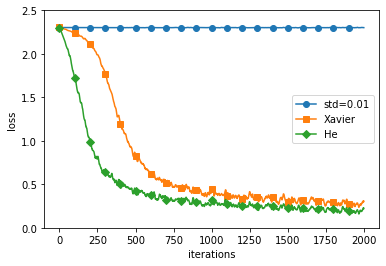

In [76]:
import sys, os
sys.path.append(os.pardir) # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from mnist import load_mnist

# 0. MNIST 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000

# 1. 실험용 설정
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []
    
# 2. 훈련 시작
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)
        
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
        
    if i % 100 == 0:
        print("===========" + "iteration:" + str(i) + "===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))
            
# 3. 그래프 그리기
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()

## batch_norm_test.py

============== 1/16 ==============
epoch:0 | 0.087 - 0.13
epoch:1 | 0.097 - 0.138


C:\Users\Sangjin\AppData\Local\Temp\ipykernel_163020\2227633215.py:26: RuntimeWarning: invalid value encountered in subtract
  x = x - np.max(x, axis=0)


epoch:2 | 0.097 - 0.198
epoch:3 | 0.097 - 0.201
epoch:4 | 0.097 - 0.23
epoch:5 | 0.097 - 0.253
epoch:6 | 0.097 - 0.281
epoch:7 | 0.097 - 0.305
epoch:8 | 0.097 - 0.321
epoch:9 | 0.097 - 0.336
epoch:10 | 0.097 - 0.349
epoch:11 | 0.097 - 0.357
epoch:12 | 0.097 - 0.38
epoch:13 | 0.097 - 0.384
epoch:14 | 0.097 - 0.405
epoch:15 | 0.097 - 0.41
epoch:16 | 0.097 - 0.414
epoch:17 | 0.097 - 0.432
epoch:18 | 0.097 - 0.448
epoch:19 | 0.097 - 0.456
============== 2/16 ==============
epoch:0 | 0.099 - 0.102


C:\Users\Sangjin\AppData\Local\Temp\ipykernel_163020\3457538939.py:100: RuntimeWarning: overflow encountered in square
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
C:\Users\Sangjin\AppData\Local\Temp\ipykernel_163020\3457538939.py:100: RuntimeWarning: invalid value encountered in double_scalars
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)


epoch:1 | 0.097 - 0.102
epoch:2 | 0.097 - 0.135
epoch:3 | 0.097 - 0.172
epoch:4 | 0.097 - 0.199
epoch:5 | 0.097 - 0.214
epoch:6 | 0.097 - 0.243
epoch:7 | 0.097 - 0.269
epoch:8 | 0.097 - 0.282
epoch:9 | 0.097 - 0.312
epoch:10 | 0.097 - 0.331
epoch:11 | 0.097 - 0.341
epoch:12 | 0.097 - 0.362
epoch:13 | 0.097 - 0.381
epoch:14 | 0.097 - 0.405
epoch:15 | 0.097 - 0.436
epoch:16 | 0.097 - 0.45
epoch:17 | 0.097 - 0.46
epoch:18 | 0.097 - 0.473
epoch:19 | 0.097 - 0.491
============== 3/16 ==============
epoch:0 | 0.153 - 0.113
epoch:1 | 0.418 - 0.118
epoch:2 | 0.501 - 0.157
epoch:3 | 0.587 - 0.193
epoch:4 | 0.631 - 0.232
epoch:5 | 0.714 - 0.279
epoch:6 | 0.758 - 0.326
epoch:7 | 0.798 - 0.367
epoch:8 | 0.834 - 0.394
epoch:9 | 0.851 - 0.42
epoch:10 | 0.872 - 0.449
epoch:11 | 0.889 - 0.47
epoch:12 | 0.921 - 0.498
epoch:13 | 0.928 - 0.516
epoch:14 | 0.942 - 0.544
epoch:15 | 0.951 - 0.57
epoch:16 | 0.959 - 0.594
epoch:17 | 0.961 - 0.604
epoch:18 | 0.968 - 0.627
epoch:19 | 0.973 - 0.643
==============

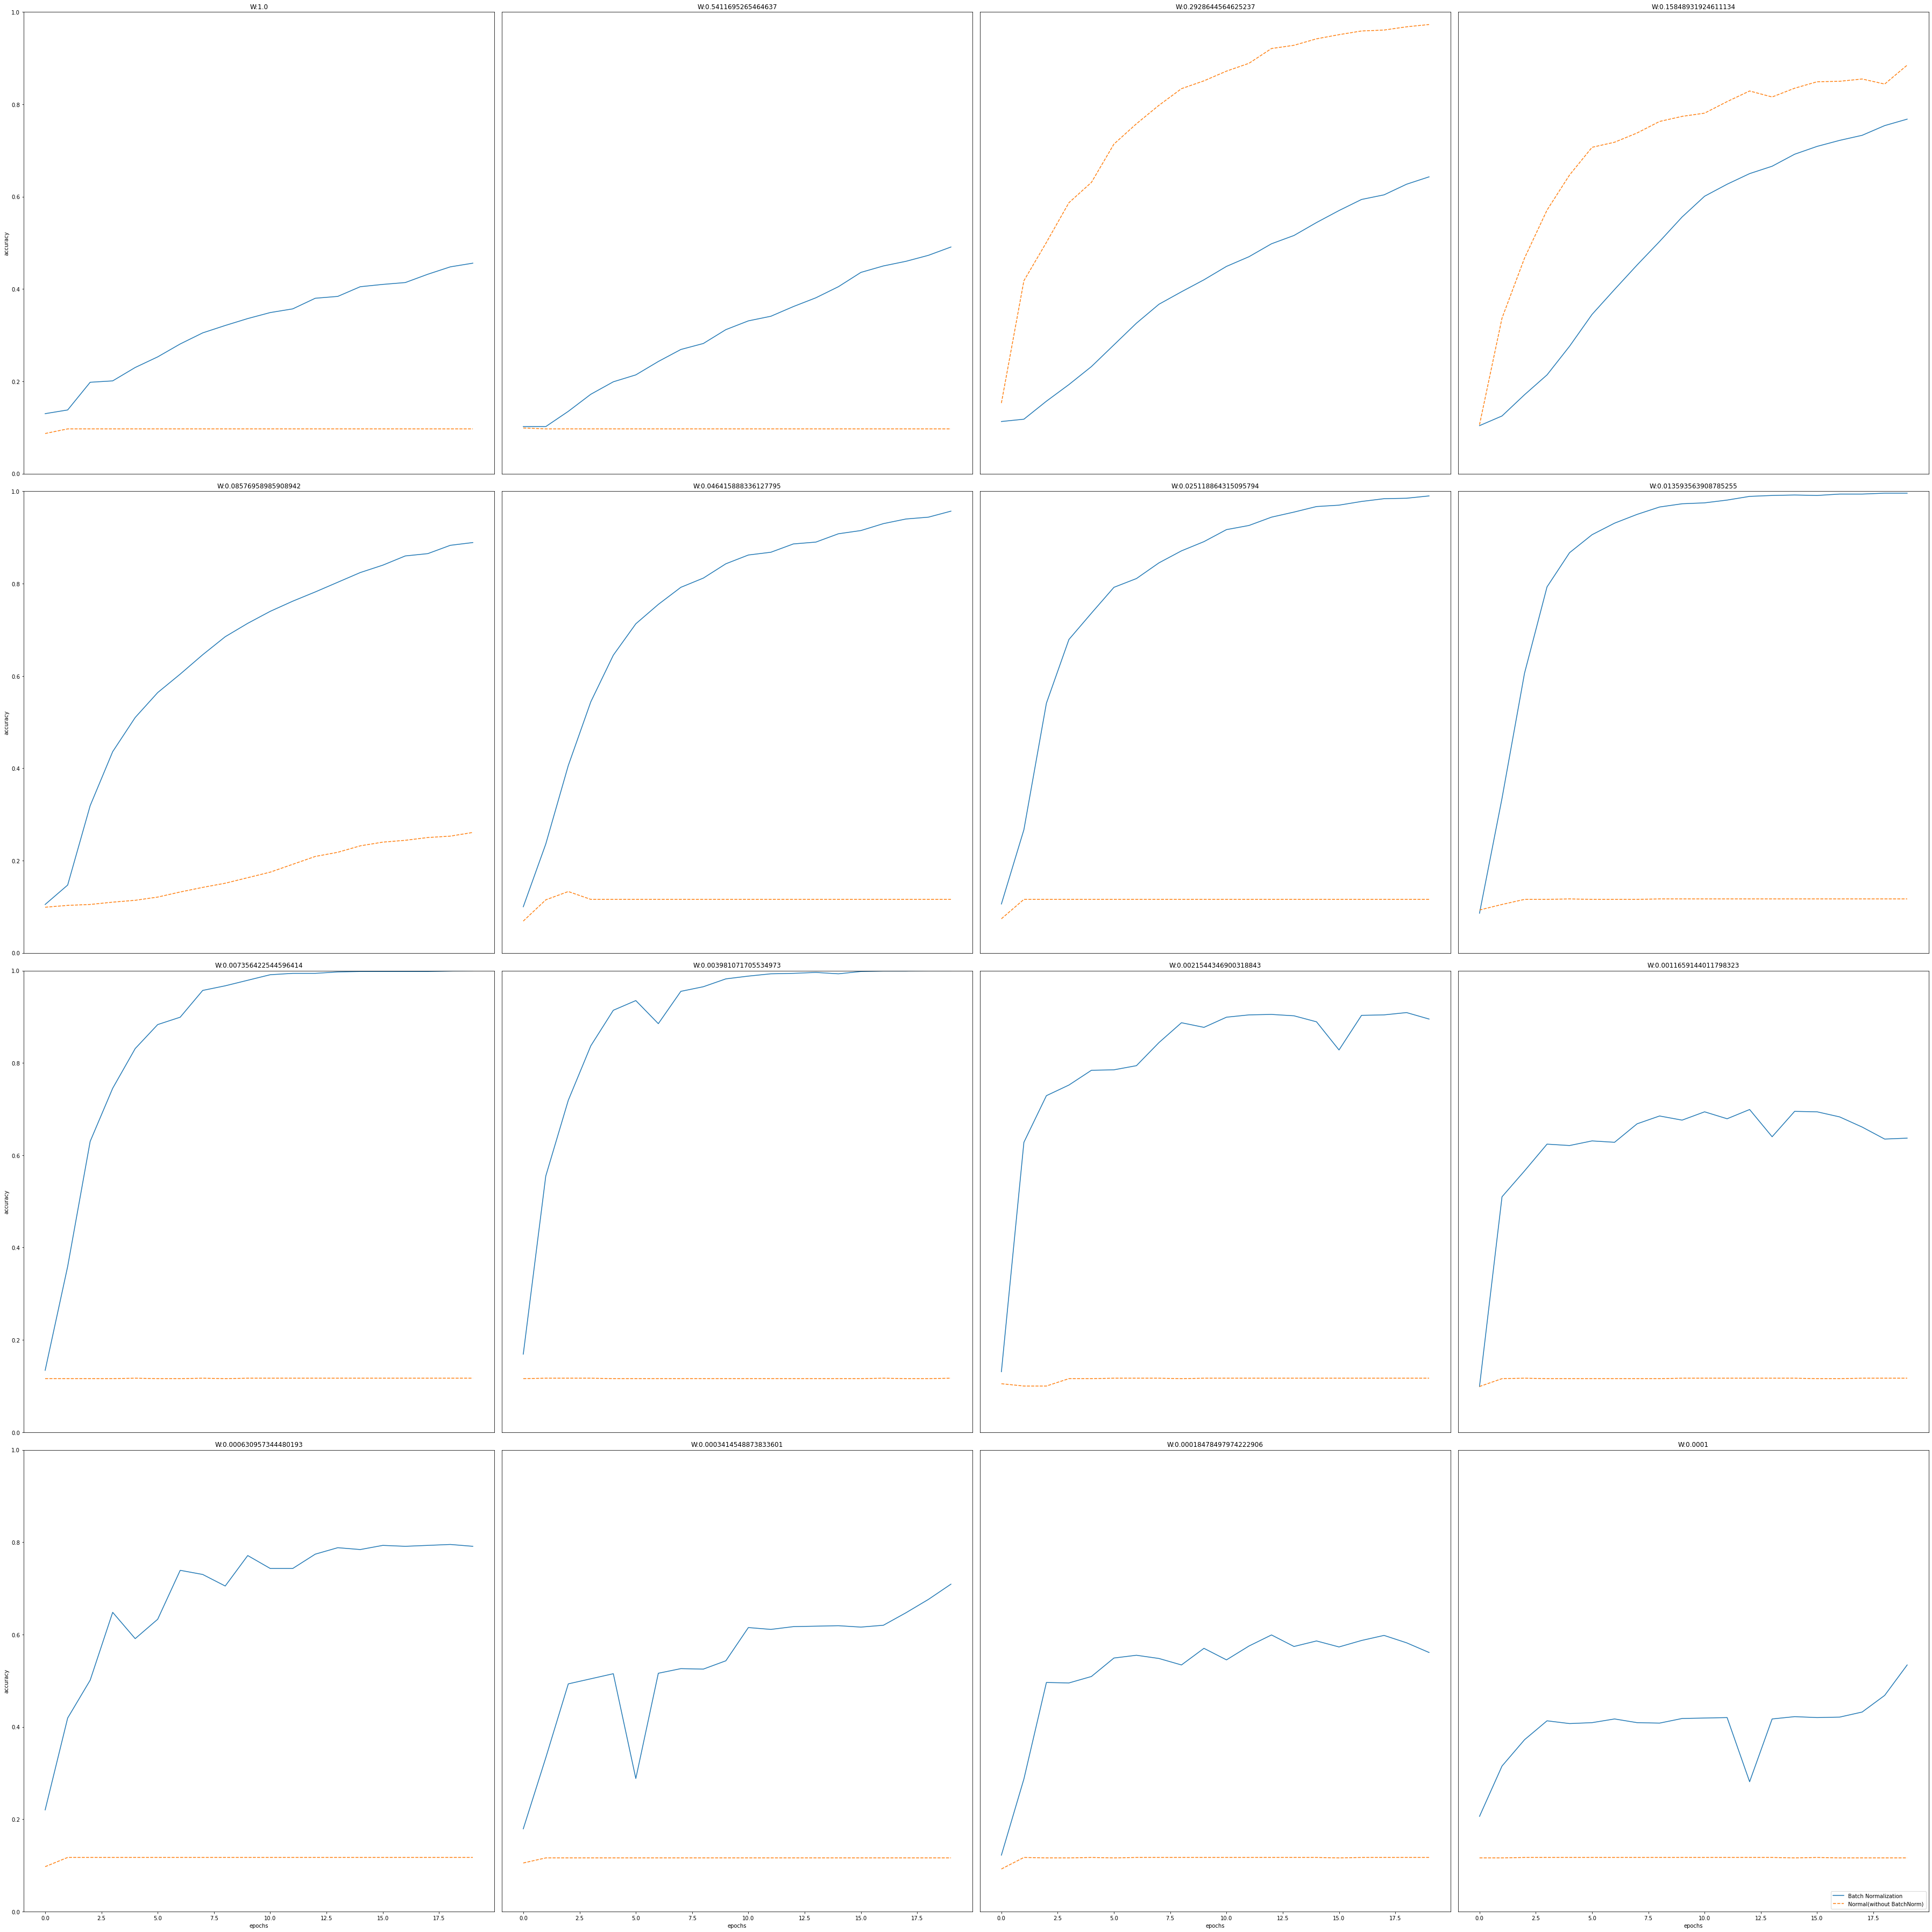

In [96]:
import sys, os
sys.path.append(os.pardir) # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 학습 데이터를 줄임
x_train = x_train[:1000]
t_train = t_train[:1000]

max_epochs = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01


def __train(weight_init_std):
    bn_network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10, 
                                    weight_init_std=weight_init_std, use_batchnorm=True)
    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10,
                                weight_init_std=weight_init_std)
    optimizer = SGD(lr=learning_rate)
    
    train_acc_list = []
    bn_train_acc_list = []
    
    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0
    
    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
    
        for _network in (bn_network, network):
            grads = _network.gradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)
    
        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            bn_train_acc = bn_network.accuracy(x_train, t_train)
            train_acc_list.append(train_acc)
            bn_train_acc_list.append(bn_train_acc)
    
            print("epoch:" + str(epoch_cnt) + " | " + str(train_acc) + " - " + str(bn_train_acc))
    
            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break
                
    return train_acc_list, bn_train_acc_list


# 그래프 그리기==========
weight_scale_list = np.logspace(0, -4, num=16)
x = np.arange(max_epochs)

plt.figure(figsize=(50, 50))
for i, w in enumerate(weight_scale_list):
    print( "============== " + str(i+1) + "/16" + " ==============")
    train_acc_list, bn_train_acc_list = __train(w)
    
    plt.subplot(4,4,i+1)
    plt.title("W:" + str(w))
    if i == 15:
        plt.plot(x, bn_train_acc_list, label='Batch Normalization', markevery=2)
        plt.plot(x, train_acc_list, linestyle = "--", label='Normal(without BatchNorm)', markevery=2)
    else:
        plt.plot(x, bn_train_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle="--", markevery=2)

    plt.ylim(0, 1.0)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("epochs")
    
plt.legend(loc='lower right')    
plt.tight_layout()
plt.show()

## overfit_weight_decay.py

epoch:0, train acc:0.10666666666666667, test acc:0.1054
epoch:1, train acc:0.13, test acc:0.1227
epoch:2, train acc:0.13666666666666666, test acc:0.1327
epoch:3, train acc:0.18, test acc:0.1497
epoch:4, train acc:0.21666666666666667, test acc:0.1647
epoch:5, train acc:0.2733333333333333, test acc:0.1875
epoch:6, train acc:0.30333333333333334, test acc:0.2109
epoch:7, train acc:0.35, test acc:0.2418
epoch:8, train acc:0.37333333333333335, test acc:0.2638
epoch:9, train acc:0.37, test acc:0.2794
epoch:10, train acc:0.39666666666666667, test acc:0.3025
epoch:11, train acc:0.42, test acc:0.3138
epoch:12, train acc:0.4033333333333333, test acc:0.3296
epoch:13, train acc:0.4166666666666667, test acc:0.343
epoch:14, train acc:0.43333333333333335, test acc:0.3525
epoch:15, train acc:0.47, test acc:0.371
epoch:16, train acc:0.47333333333333333, test acc:0.3814
epoch:17, train acc:0.49333333333333335, test acc:0.3872
epoch:18, train acc:0.52, test acc:0.4025
epoch:19, train acc:0.546666666666666

epoch:167, train acc:1.0, test acc:0.7609
epoch:168, train acc:1.0, test acc:0.7644
epoch:169, train acc:1.0, test acc:0.7654
epoch:170, train acc:1.0, test acc:0.7653
epoch:171, train acc:1.0, test acc:0.7672
epoch:172, train acc:1.0, test acc:0.764
epoch:173, train acc:1.0, test acc:0.7629
epoch:174, train acc:1.0, test acc:0.7659
epoch:175, train acc:1.0, test acc:0.7646
epoch:176, train acc:1.0, test acc:0.762
epoch:177, train acc:1.0, test acc:0.764
epoch:178, train acc:1.0, test acc:0.7643
epoch:179, train acc:1.0, test acc:0.7659
epoch:180, train acc:1.0, test acc:0.7656
epoch:181, train acc:1.0, test acc:0.7646
epoch:182, train acc:1.0, test acc:0.7672
epoch:183, train acc:1.0, test acc:0.7673
epoch:184, train acc:1.0, test acc:0.7664
epoch:185, train acc:1.0, test acc:0.7671
epoch:186, train acc:1.0, test acc:0.7653
epoch:187, train acc:1.0, test acc:0.7693
epoch:188, train acc:1.0, test acc:0.7666
epoch:189, train acc:1.0, test acc:0.7676
epoch:190, train acc:1.0, test acc:0.

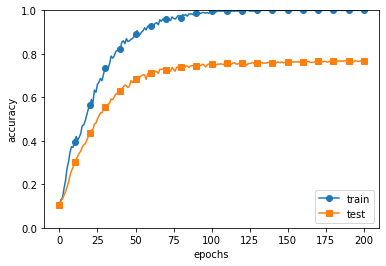

In [106]:
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# weight decay（가중치 감쇠） 설정 =======================
weight_decay_lambda = 0
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01) # 학습률이 0.01인 SGD로 매개변수 갱신

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break


# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

epoch:0, train acc:0.10333333333333333, test acc:0.1032
epoch:1, train acc:0.11666666666666667, test acc:0.1109
epoch:2, train acc:0.15, test acc:0.1242
epoch:3, train acc:0.17333333333333334, test acc:0.1403
epoch:4, train acc:0.19666666666666666, test acc:0.1609
epoch:5, train acc:0.24333333333333335, test acc:0.1908
epoch:6, train acc:0.2833333333333333, test acc:0.2229
epoch:7, train acc:0.32, test acc:0.2483
epoch:8, train acc:0.37666666666666665, test acc:0.2647
epoch:9, train acc:0.38666666666666666, test acc:0.2818
epoch:10, train acc:0.41, test acc:0.297
epoch:11, train acc:0.43333333333333335, test acc:0.311
epoch:12, train acc:0.46, test acc:0.3308
epoch:13, train acc:0.48, test acc:0.3385
epoch:14, train acc:0.49666666666666665, test acc:0.3511
epoch:15, train acc:0.5133333333333333, test acc:0.3696
epoch:16, train acc:0.5166666666666667, test acc:0.3797
epoch:17, train acc:0.54, test acc:0.3932
epoch:18, train acc:0.52, test acc:0.3964
epoch:19, train acc:0.553333333333333

epoch:160, train acc:0.8766666666666667, test acc:0.7086
epoch:161, train acc:0.88, test acc:0.7059
epoch:162, train acc:0.8666666666666667, test acc:0.7025
epoch:163, train acc:0.8766666666666667, test acc:0.6994
epoch:164, train acc:0.8666666666666667, test acc:0.7026
epoch:165, train acc:0.8633333333333333, test acc:0.6967
epoch:166, train acc:0.88, test acc:0.7095
epoch:167, train acc:0.8766666666666667, test acc:0.7085
epoch:168, train acc:0.8833333333333333, test acc:0.7053
epoch:169, train acc:0.8766666666666667, test acc:0.7051
epoch:170, train acc:0.8733333333333333, test acc:0.7009
epoch:171, train acc:0.88, test acc:0.7038
epoch:172, train acc:0.8833333333333333, test acc:0.7001
epoch:173, train acc:0.8766666666666667, test acc:0.7069
epoch:174, train acc:0.88, test acc:0.7038
epoch:175, train acc:0.8733333333333333, test acc:0.6949
epoch:176, train acc:0.8766666666666667, test acc:0.6953
epoch:177, train acc:0.8866666666666667, test acc:0.7026
epoch:178, train acc:0.8833333

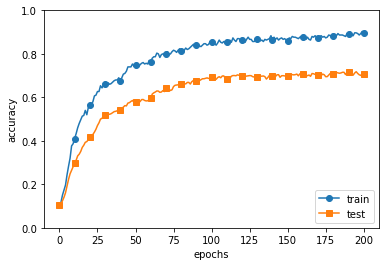

In [107]:
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# weight decay（가중치 감쇠） 설정 =======================
#weight_decay_lambda = 0 # weight decay를 사용하지 않을 경우
weight_decay_lambda = 0.1
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01) # 학습률이 0.01인 SGD로 매개변수 갱신

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break


# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

## overfit_dropout.py

train loss:2.2754831983894395
=== epoch:1, train acc:0.10666666666666667, test acc:0.0874 ===
train loss:2.3008311881724266
train loss:2.241580757829057
train loss:2.2533900406573046
=== epoch:2, train acc:0.12, test acc:0.1084 ===
train loss:2.2246766665777638
train loss:2.2541137467703782
train loss:2.237007890644196
=== epoch:3, train acc:0.15666666666666668, test acc:0.1299 ===
train loss:2.237140182852977
train loss:2.2000863975412766
train loss:2.1755282923502826
=== epoch:4, train acc:0.19, test acc:0.157 ===
train loss:2.133859957487749
train loss:2.187641838778027
train loss:2.1963199081680678
=== epoch:5, train acc:0.25666666666666665, test acc:0.1787 ===
train loss:2.158412663964784
train loss:2.1552308432361347
train loss:2.1237377958974757
=== epoch:6, train acc:0.3233333333333333, test acc:0.2073 ===
train loss:2.1495138783481966
train loss:2.133744442591195
train loss:2.1101716324087327
=== epoch:7, train acc:0.3466666666666667, test acc:0.2388 ===
train loss:2.136899169

train loss:0.4435945407843178
train loss:0.3871710437480621
train loss:0.4006891827011711
=== epoch:57, train acc:0.92, test acc:0.6787 ===
train loss:0.44890716041041323
train loss:0.3351707925907757
train loss:0.41644417977668674
=== epoch:58, train acc:0.9166666666666666, test acc:0.685 ===
train loss:0.2590989727779444
train loss:0.4454929016013589
train loss:0.3632967805703612
=== epoch:59, train acc:0.96, test acc:0.6938 ===
train loss:0.2959964665579037
train loss:0.357915042351975
train loss:0.351669790438467
=== epoch:60, train acc:0.9333333333333333, test acc:0.6828 ===
train loss:0.28278090946896933
train loss:0.31115355285855745
train loss:0.27027311099935053
=== epoch:61, train acc:0.9333333333333333, test acc:0.6973 ===
train loss:0.3090552209548841
train loss:0.310117666703691
train loss:0.2449147501393668
=== epoch:62, train acc:0.9566666666666667, test acc:0.6973 ===
train loss:0.31893768685961393
train loss:0.3223068786385126
train loss:0.3002231255193416
=== epoch:63

train loss:0.051582269649778405
=== epoch:112, train acc:1.0, test acc:0.7473 ===
train loss:0.056982611346607766
train loss:0.06459119871275648
train loss:0.06488678156289865
=== epoch:113, train acc:1.0, test acc:0.7474 ===
train loss:0.047494097675917314
train loss:0.06065028601499425
train loss:0.06627660663762554
=== epoch:114, train acc:1.0, test acc:0.7452 ===
train loss:0.06853651192658294
train loss:0.0520154687942036
train loss:0.05685081990593008
=== epoch:115, train acc:1.0, test acc:0.7476 ===
train loss:0.058626620845774725
train loss:0.0530819052100309
train loss:0.06903562070649218
=== epoch:116, train acc:1.0, test acc:0.7497 ===
train loss:0.04675389290394878
train loss:0.05479569499166398
train loss:0.056456136821438914
=== epoch:117, train acc:1.0, test acc:0.751 ===
train loss:0.054481816401779674
train loss:0.05558126611062948
train loss:0.06326288734421563
=== epoch:118, train acc:1.0, test acc:0.7505 ===
train loss:0.06266828131753278
train loss:0.04395846877237

=== epoch:169, train acc:1.0, test acc:0.7576 ===
train loss:0.023637471533069995
train loss:0.023278649939135802
train loss:0.018390302464009096
=== epoch:170, train acc:1.0, test acc:0.7577 ===
train loss:0.021577417014211547
train loss:0.01699082117258175
train loss:0.016197253814790456
=== epoch:171, train acc:1.0, test acc:0.7584 ===
train loss:0.021598893951188653
train loss:0.021043609754071765
train loss:0.02754651658167199
=== epoch:172, train acc:1.0, test acc:0.7567 ===
train loss:0.021357204886739284
train loss:0.019290814998438318
train loss:0.0239447945711021
=== epoch:173, train acc:1.0, test acc:0.7567 ===
train loss:0.028376788183640343
train loss:0.023850095376941053
train loss:0.01983203305601053
=== epoch:174, train acc:1.0, test acc:0.7584 ===
train loss:0.02098199855125511
train loss:0.026779573224608985
train loss:0.02067987835687165
=== epoch:175, train acc:1.0, test acc:0.7573 ===
train loss:0.020347264865925606
train loss:0.023552350010915143
train loss:0.0327

train loss:0.012333985639180266
train loss:0.01262015033997871
=== epoch:227, train acc:1.0, test acc:0.7628 ===
train loss:0.012542147516815332
train loss:0.009574519358725308
train loss:0.012073962210777126
=== epoch:228, train acc:1.0, test acc:0.7616 ===
train loss:0.012695268678311085
train loss:0.01076635162945196
train loss:0.013459685993066219
=== epoch:229, train acc:1.0, test acc:0.7613 ===
train loss:0.012092573743653025
train loss:0.011199999461832763
train loss:0.013180212005879821
=== epoch:230, train acc:1.0, test acc:0.7619 ===
train loss:0.015623144482130626
train loss:0.012421651195992351
train loss:0.012780120173568544
=== epoch:231, train acc:1.0, test acc:0.7613 ===
train loss:0.009719414865605656
train loss:0.012215121013045883
train loss:0.009893391798111469
=== epoch:232, train acc:1.0, test acc:0.7608 ===
train loss:0.011675813212787793
train loss:0.014572747752206348
train loss:0.009238250622189288
=== epoch:233, train acc:1.0, test acc:0.7621 ===
train loss:0

=== epoch:284, train acc:1.0, test acc:0.7636 ===
train loss:0.00916079321676131
train loss:0.006570350312438338
train loss:0.0077776967629123
=== epoch:285, train acc:1.0, test acc:0.7626 ===
train loss:0.00744120007889954
train loss:0.007383922806118305
train loss:0.007282323056441957
=== epoch:286, train acc:1.0, test acc:0.763 ===
train loss:0.009758245173370627
train loss:0.007308369790588096
train loss:0.009961560636779361
=== epoch:287, train acc:1.0, test acc:0.7633 ===
train loss:0.00845607028171922
train loss:0.008074552044429846
train loss:0.01009381720089812
=== epoch:288, train acc:1.0, test acc:0.7635 ===
train loss:0.008816249729175175
train loss:0.008935781200113117
train loss:0.005821716540985579
=== epoch:289, train acc:1.0, test acc:0.7636 ===
train loss:0.007240986051494977
train loss:0.008037352356985578
train loss:0.006861561454381099
=== epoch:290, train acc:1.0, test acc:0.7623 ===
train loss:0.008843639427222619
train loss:0.006010221724085846
train loss:0.0057

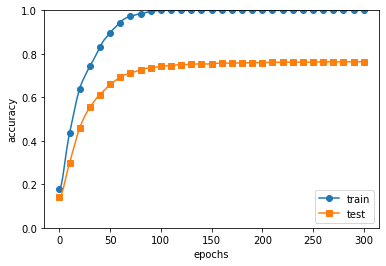

In [112]:
import sys, os
sys.path.append(os.pardir) # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# 드롭아웃 사용 유무와 비율 설정
use_dropout = False # 드롭아웃을 쓰지 않을 때는 False
#dropout_ratio = 0.2

network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                              output_size=10, use_dropout=use_dropout, dropout_ration=dropout_ratio)
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=True)
trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

# 그래프 그리기
marker = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, smooth_curve(train_acc_list), marker='o', label='train', markevery=10)
plt.plot(x, smooth_curve(test_acc_list), marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(loc='lower right')
plt.ylim(0, 1.0)
plt.show()

train loss:2.2940025529895642
=== epoch:1, train acc:0.1, test acc:0.1026 ===
train loss:2.3097430923529716
train loss:2.310574494226715
train loss:2.298688966776812
=== epoch:2, train acc:0.09666666666666666, test acc:0.1036 ===
train loss:2.324912665894003
train loss:2.316567432169826
train loss:2.304309315893173
=== epoch:3, train acc:0.10333333333333333, test acc:0.108 ===
train loss:2.3066322775184402
train loss:2.3001514618843575
train loss:2.295989927007991
=== epoch:4, train acc:0.11666666666666667, test acc:0.1097 ===
train loss:2.3045330690034618
train loss:2.296298394854149
train loss:2.295439560488045
=== epoch:5, train acc:0.12, test acc:0.1118 ===
train loss:2.3056676582924
train loss:2.287264841297686
train loss:2.2992339543817555
=== epoch:6, train acc:0.12, test acc:0.1126 ===
train loss:2.3100628645965595
train loss:2.3015488103796624
train loss:2.3105442837674683
=== epoch:7, train acc:0.11666666666666667, test acc:0.1149 ===
train loss:2.295800192393959
train loss:2

train loss:2.253091018022959
train loss:2.2379206188303638
train loss:2.193322331583252
=== epoch:57, train acc:0.21666666666666667, test acc:0.179 ===
train loss:2.2346026985692276
train loss:2.210470361074371
train loss:2.189725425181622
=== epoch:58, train acc:0.20333333333333334, test acc:0.1724 ===
train loss:2.2444113951098235
train loss:2.2132102902232007
train loss:2.2301496686884916
=== epoch:59, train acc:0.21666666666666667, test acc:0.1803 ===
train loss:2.2167187501337313
train loss:2.203491211686789
train loss:2.2385020476068274
=== epoch:60, train acc:0.21333333333333335, test acc:0.1803 ===
train loss:2.1869963703350432
train loss:2.22800790711142
train loss:2.2203991786917183
=== epoch:61, train acc:0.21333333333333335, test acc:0.1825 ===
train loss:2.214079933689611
train loss:2.2084834869883947
train loss:2.1847662823845484
=== epoch:62, train acc:0.21333333333333335, test acc:0.1782 ===
train loss:2.179847420155462
train loss:2.171836271556168
train loss:2.25310993

train loss:2.112479273255106
train loss:2.0849096008016503
train loss:2.1228644781324526
=== epoch:112, train acc:0.35333333333333333, test acc:0.2756 ===
train loss:2.1347741250372554
train loss:2.1134746564299083
train loss:2.110635558149609
=== epoch:113, train acc:0.36, test acc:0.2834 ===
train loss:2.079363024156201
train loss:2.0857851913647565
train loss:2.123424399220561
=== epoch:114, train acc:0.37333333333333335, test acc:0.2875 ===
train loss:1.9681183878719244
train loss:2.0394760781195034
train loss:2.010087547865019
=== epoch:115, train acc:0.36666666666666664, test acc:0.2834 ===
train loss:2.1033038080317903
train loss:2.059009373749889
train loss:2.004441836616143
=== epoch:116, train acc:0.36666666666666664, test acc:0.2833 ===
train loss:2.109043492530808
train loss:1.9966092378268003
train loss:2.130855785614346
=== epoch:117, train acc:0.37333333333333335, test acc:0.2864 ===
train loss:2.022627757939
train loss:2.0867225458167002
train loss:2.1277121207781478
==

=== epoch:167, train acc:0.5133333333333333, test acc:0.3818 ===
train loss:1.9553125028379987
train loss:1.924375758041341
train loss:1.8887295283996028
=== epoch:168, train acc:0.51, test acc:0.3818 ===
train loss:1.8241433201203359
train loss:1.8540352286364299
train loss:1.91767918223293
=== epoch:169, train acc:0.5166666666666667, test acc:0.3852 ===
train loss:1.8596325845886477
train loss:1.961551049983958
train loss:1.819582958131492
=== epoch:170, train acc:0.51, test acc:0.3827 ===
train loss:1.94103531051114
train loss:1.8636128680489856
train loss:1.8760945362817887
=== epoch:171, train acc:0.51, test acc:0.3847 ===
train loss:1.879769079943022
train loss:1.9387830996223474
train loss:1.7809865975944374
=== epoch:172, train acc:0.5233333333333333, test acc:0.3893 ===
train loss:1.9341367910009746
train loss:1.8242776407487518
train loss:1.885980843725853
=== epoch:173, train acc:0.5133333333333333, test acc:0.3888 ===
train loss:1.8018169857285269
train loss:1.9039924029732

train loss:1.729484330861495
train loss:1.5559160040608142
=== epoch:223, train acc:0.59, test acc:0.4689 ===
train loss:1.7526182093140645
train loss:1.6593796548148654
train loss:1.5451611368524616
=== epoch:224, train acc:0.5966666666666667, test acc:0.4681 ===
train loss:1.5374833807528412
train loss:1.4529583477399228
train loss:1.5801852583725333
=== epoch:225, train acc:0.5866666666666667, test acc:0.4669 ===
train loss:1.5606088179011286
train loss:1.5789144455544468
train loss:1.4887468744941208
=== epoch:226, train acc:0.5833333333333334, test acc:0.465 ===
train loss:1.7162577780429897
train loss:1.533405785507997
train loss:1.6807584352663631
=== epoch:227, train acc:0.5833333333333334, test acc:0.4694 ===
train loss:1.7259563433221077
train loss:1.514936720528895
train loss:1.5349369154072239
=== epoch:228, train acc:0.5833333333333334, test acc:0.4701 ===
train loss:1.6252927206835894
train loss:1.4642747233829374
train loss:1.5231830800530712
=== epoch:229, train acc:0.5

train loss:1.290372916259851
=== epoch:278, train acc:0.6733333333333333, test acc:0.5441 ===
train loss:1.2933626366697493
train loss:1.2755097024264943
train loss:1.3518218538787905
=== epoch:279, train acc:0.6766666666666666, test acc:0.5452 ===
train loss:1.372791694129107
train loss:1.392526258103112
train loss:1.371250777409695
=== epoch:280, train acc:0.6766666666666666, test acc:0.546 ===
train loss:1.3473577865238329
train loss:1.3600393626538068
train loss:1.2257245512424624
=== epoch:281, train acc:0.68, test acc:0.5492 ===
train loss:1.3579865366223074
train loss:1.4283529904863728
train loss:1.337108765263305
=== epoch:282, train acc:0.68, test acc:0.5502 ===
train loss:1.377362978770299
train loss:1.3923384592440695
train loss:1.1952299638735082
=== epoch:283, train acc:0.68, test acc:0.5531 ===
train loss:1.3747141519838946
train loss:1.3281913144098374
train loss:1.3210032081624303
=== epoch:284, train acc:0.68, test acc:0.5568 ===
train loss:1.350202998236676
train los

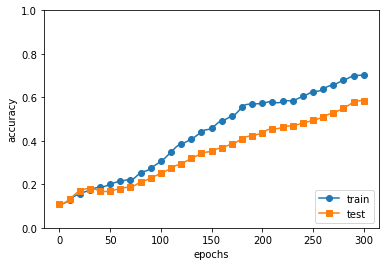

In [111]:
import sys, os
sys.path.append(os.pardir) # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

# 드롭아웃 사용 유무와 비율 설정
use_dropout = True # 드롭아웃을 쓰지 않을 때는 False
dropout_ratio = 0.2

network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                              output_size=10, use_dropout=use_dropout, dropout_ration=dropout_ratio)
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=True)
trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

# 그래프 그리기
marker = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, smooth_curve(train_acc_list), marker='o', label='train', markevery=10)
plt.plot(x, smooth_curve(test_acc_list), marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(loc='lower right')
plt.ylim(0, 1.0)
plt.show()

## hyperparameter_optimization.py

val acc:0.2 | lr:0.0009940444139543059, weight decay:6.7038026577276495e-06
val acc:0.25 | lr:0.001977908751859522, weight decay:4.9673427716879925e-06
val acc:0.74 | lr:0.005714910126113972, weight decay:7.140874671023686e-06
val acc:0.18 | lr:0.0010796387092414541, weight decay:2.8923818176826993e-07
val acc:0.09 | lr:0.00024378884947255406, weight decay:1.2801920336416657e-07
val acc:0.1 | lr:4.047531357521887e-06, weight decay:9.286306105991217e-06
val acc:0.1 | lr:3.836429390976051e-06, weight decay:2.668673549269556e-06
val acc:0.13 | lr:0.0001807886833637096, weight decay:2.5740738498149812e-08
val acc:0.1 | lr:2.4479879380491478e-05, weight decay:7.043522118418019e-06
val acc:0.06 | lr:1.3108103989154876e-05, weight decay:1.2966596407023186e-07
val acc:0.16 | lr:0.0005609750569969401, weight decay:7.644616681898893e-07
val acc:0.77 | lr:0.007391357085122963, weight decay:7.7200034551685e-06
val acc:0.08 | lr:1.3922086765528803e-05, weight decay:8.421368845683825e-07
val acc:0.1

Best-10(val acc:0.73) | lr:0.00769282483641768, weight decay:6.404802916280898e-05
Best-11(val acc:0.72) | lr:0.006185314119867643, weight decay:1.9645813188046698e-07
Best-12(val acc:0.44) | lr:0.002323344355165874, weight decay:9.950385852834573e-06
Best-13(val acc:0.37) | lr:0.0016692514865973684, weight decay:4.8898893515562935e-06
Best-14(val acc:0.37) | lr:0.0016510836408310389, weight decay:6.416492071570625e-06
Best-15(val acc:0.34) | lr:0.0007492383447914616, weight decay:2.433405882297431e-06
Best-16(val acc:0.26) | lr:0.0013193937911650194, weight decay:7.649777877076215e-05
Best-17(val acc:0.25) | lr:0.001977908751859522, weight decay:4.9673427716879925e-06
Best-18(val acc:0.24) | lr:0.0012288839920466229, weight decay:1.0332296907990833e-08
Best-19(val acc:0.2) | lr:0.0009940444139543059, weight decay:6.7038026577276495e-06
Best-20(val acc:0.2) | lr:0.0009997179834472273, weight decay:1.6434173048135783e-08


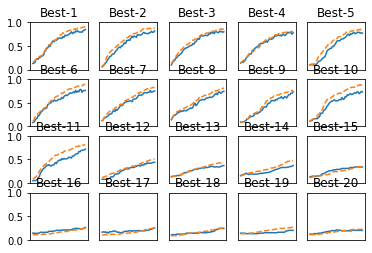

In [31]:
import sys, os
sys.path.append(os.pardir) # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 결과를 빠르게 얻기 위해 훈련 데이터를 줄임
x_train = x_train[:500]
t_train = t_train[:500]

# 20%를 검증 데이터로 분할
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)
x_train, t_train = shuffle_dataset(x_train, t_train)
x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]


def __train(lr, weight_decay, epocs=50):
    network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                            output_size=10, weight_decay_lambda=weight_decay)
    trainer = Trainer(network, x_train, t_train, x_val, t_val,
                      epochs=epocs, mini_batch_size=100,
                      optimizer='sgd', optimizer_param={'lr': lr}, verbose=False)
    trainer.train()

    return trainer.test_acc_list, trainer.train_acc_list


# 하이퍼파라미터 무작위 탐색======================================
optimization_trial = 100
results_val = {}
results_train = {}
for _ in range(optimization_trial):
    # 탐색한 하이퍼파라미터의 범위 지정===============
    weight_decay = 10 ** np.random.uniform(-8, -4)
    lr = 10 ** np.random.uniform(-6, -2)
    # ================================================

    val_acc_list, train_acc_list = __train(lr, weight_decay)
    print("val acc:" + str(val_acc_list[-1]) + " | lr:" + str(lr) + ", weight decay:" + str(weight_decay))
    key = "lr:" + str(lr) + ", weight decay:" + str(weight_decay)
    results_val[key] = val_acc_list
    results_train[key] = train_acc_list

# 그래프 그리기========================================================
print("=========== Hyper-Parameter Optimization Result ===========")
graph_draw_num = 20
col_num = 5
row_num = int(np.ceil(graph_draw_num / col_num))
i = 0

for key, val_acc_list in sorted(results_val.items(), key=lambda x:x[1][-1], reverse=True):
    print("Best-" + str(i+1) + "(val acc:" + str(val_acc_list[-1]) + ") | " + key)

    plt.subplot(row_num, col_num, i+1)
    plt.title("Best-" + str(i+1))
    plt.ylim(0.0, 1.0)
    if i % 5: plt.yticks([])
    plt.xticks([])
    x = np.arange(len(val_acc_list))
    plt.plot(x, val_acc_list)
    plt.plot(x, results_train[key], "--")
    i += 1

    if i >= graph_draw_num:
        break

plt.show()

# ch07

In [9]:
x = np.random.rand(10, 1, 28, 28)
x.shape

(10, 1, 28, 28)

In [10]:
x[0].shape

(1, 28, 28)

In [11]:
x[1].shape

(1, 28, 28)

In [14]:
x[0][0]

array([[9.09472453e-01, 5.63123926e-01, 3.05175177e-01, 2.91742430e-01,
        1.94913012e-01, 6.64584568e-01, 2.05731611e-01, 8.58406020e-01,
        6.56954410e-01, 3.68024325e-01, 8.53496173e-01, 3.27480428e-01,
        7.36036481e-01, 2.76819547e-01, 1.32275372e-01, 4.03036865e-01,
        2.29014811e-02, 4.82770869e-01, 2.50577806e-01, 1.63370834e-01,
        8.22009172e-01, 8.91348895e-01, 6.63279685e-01, 1.53248636e-01,
        5.87566520e-01, 2.74788493e-01, 8.86193471e-01, 8.66185625e-01],
       [6.42908123e-01, 1.30168995e-02, 7.44875255e-01, 3.55475583e-01,
        9.94661696e-02, 1.32454955e-01, 5.71408152e-01, 6.43840761e-02,
        9.79672022e-01, 6.34882312e-01, 2.95202874e-01, 5.68220316e-01,
        8.49574872e-01, 4.89430826e-01, 3.52677028e-01, 5.23390139e-01,
        6.93183751e-01, 2.18024481e-01, 6.76093438e-01, 8.87725021e-01,
        2.40688006e-04, 3.97234427e-01, 7.91242480e-01, 7.65513896e-01,
        7.03403865e-01, 8.92058755e-01, 5.73021134e-02, 2.76661

In [20]:
x1 = np.random.rand(1, 3, 7, 7) # (데이터 수, 채널 수, 높이, 너비)
col1 = im2col(x1, 5, 5, stride=1, pad=0)
print(col1.shape)

x2 = np.random.rand(10, 3, 7, 7)
col2 = im2col(x2, 5, 5, stride=1, pad=0)
print(col2.shape)

(9, 75)
(90, 75)


In [39]:
N, C, H, W = x1.shape
stride, pad = 1, 0
filter_h, filter_w = 5, 5

out_h = (H + 2*pad - filter_h) // stride + 1
out_w = (W + 2*pad - filter_w) // stride + 1

img = np.pad(x1, [(0, 0), (0, 0), (pad, pad), (pad, pad)], 'constant')
col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

for y in range(filter_h):
    y_max = y + stride*out_h # y축으로의 필터 적용 범위
    for x in range(filter_w):
        x_max = x + stride*out_w # x축으로의 필터 적용 범위
        col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]
        
col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1).shape

(9, 125)

## simple_convnet.py

In [54]:
import sys, os
sys.path.append(os.pardir) # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import pickle
import numpy as np
class SimpleConvNet:
    """단순한 합성곱 신경망
    
    conv - relu - pool - affine - relu - affine - softmax
    
    Parameters
    ----------
    input_size : 입력 크기（MNIST의 경우엔 784）
    hidden_size_list : 각 은닉층의 뉴런 수를 담은 리스트（e.g. [100, 100, 100]）
    output_size : 출력 크기（MNIST의 경우엔 10）
    activation : 활성화 함수 - 'relu' 혹은 'sigmoid'
    weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
        'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
        'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
    """
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """손실 함수를 구한다.
        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def numerical_gradient(self, x, t):
        """기울기를 구한다（수치미분）.
        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """기울기를 구한다(오차역전파법).
        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
        
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]

## train_convnet.py

train loss:2.3002057063996943
=== epoch:1, train acc:0.224, test acc:0.196 ===
train loss:2.299135608958837
train loss:2.2976659954628658
train loss:2.2914201598393924
train loss:2.285456387551836
train loss:2.27554548749949
train loss:2.2623349155555523
train loss:2.2519296894593084
train loss:2.2358873019295675
train loss:2.2104004883266732
train loss:2.186811832590301
train loss:2.165820875815639
train loss:2.1190593797235295
train loss:2.0661498410499943
train loss:2.0176657356302248
train loss:1.9427719091179128
train loss:1.8507170025154982
train loss:1.8150127420833027
train loss:1.7716292080173661
train loss:1.634137480268063
train loss:1.6168431766574443
train loss:1.5686930933276886
train loss:1.4793014872488985
train loss:1.3567033044216061
train loss:1.2991504585680003
train loss:1.2287028497921821
train loss:1.0597894462682533
train loss:1.0374182883623357
train loss:1.011041682803665
train loss:0.9440340652767527
train loss:0.9624076641847802
train loss:0.7357021652270648

train loss:0.17777454250380323
train loss:0.13238019953268862
train loss:0.2728948122668938
train loss:0.11824010223988209
train loss:0.2647257253908956
train loss:0.1605150486206442
train loss:0.33106685182129003
train loss:0.08984197249913464
train loss:0.2020151922254223
train loss:0.16931936029497383
train loss:0.27169264168494645
train loss:0.09168858357293957
train loss:0.13995285079686967
train loss:0.1457513456026709
train loss:0.20836387753217805
train loss:0.15250419755677178
train loss:0.11197351142348669
train loss:0.2333248413477416
train loss:0.20450133795108422
train loss:0.17547478626678206
train loss:0.22904546749943272
train loss:0.13543568941723033
train loss:0.23387816451572335
train loss:0.1700123258210502
train loss:0.2760575924438997
train loss:0.18442472143171337
train loss:0.1476735998250108
train loss:0.11742650447124219
train loss:0.08629565114260437
train loss:0.20524232332641756
train loss:0.12933817257900848
train loss:0.12394957043482709
train loss:0.2995

train loss:0.11033211839485674
train loss:0.03181393470183457
train loss:0.17593353420101043
train loss:0.06591604227828632
train loss:0.039246742758733
train loss:0.10943614778767677
train loss:0.05450317630722208
train loss:0.025532619517602186
train loss:0.09070000558548404
train loss:0.14151543944363573
train loss:0.06896882463269137
train loss:0.05233954908404059
train loss:0.08639638515110085
train loss:0.0622972146515568
train loss:0.08101598896135057
train loss:0.04749912097821188
train loss:0.10573796503764911
train loss:0.08459694348901324
train loss:0.050166536024743136
train loss:0.056652249102919286
train loss:0.035768381848712484
train loss:0.14917681481038142
train loss:0.04805572839879869
train loss:0.042137146521170524
train loss:0.05681339582396216
train loss:0.02789092248118527
train loss:0.08835585682953946
train loss:0.05348294089621051
train loss:0.08583195291127359
train loss:0.06779828827654624
train loss:0.0417459448109902
train loss:0.07063029873940777
train l

train loss:0.020201723030850608
train loss:0.04630035089339524
train loss:0.03326155345609152
train loss:0.04543554705059684
train loss:0.018851848234619037
train loss:0.030815349408970235
train loss:0.03532829838651458
train loss:0.05946489823437542
train loss:0.018478480574442267
train loss:0.017967160998648604
train loss:0.03440121821238793
train loss:0.023892048706358814
train loss:0.02516448693844784
train loss:0.023070624607008615
train loss:0.026765339558094178
train loss:0.0322254673558246
train loss:0.023439624950059468
train loss:0.07460041379588955
train loss:0.049203694548071795
train loss:0.044331264230347694
train loss:0.026696525840398867
train loss:0.030684250334094686
train loss:0.049754151927495605
train loss:0.019658871431030105
train loss:0.034478360996871425
train loss:0.016492341747174625
train loss:0.05518100819055664
train loss:0.011472004080138678
=== epoch:17, train acc:0.986, test acc:0.958 ===
train loss:0.026530958876072517
train loss:0.030935517754449696
t

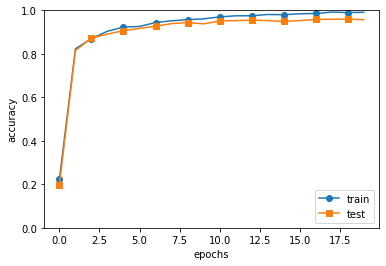

In [64]:
# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 시간이 오래 걸릴 경우 데이터를 줄인다.
x_train, t_train = x_train[:5000], t_train[:5000]
x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# 매개변수 보존
network.save_params("params.pkl")
print("Saved Network Parameters!")

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

## visualize_filter.py

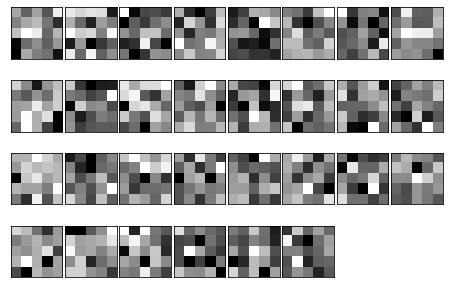

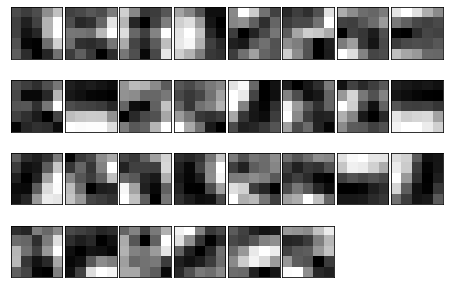

In [68]:
import numpy as np
import matplotlib.pyplot as plt

def filter_show(filters, nx=8, margin=3, scale=10):
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(FN / nx))
    
    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
    
    for i in range(FN):
        ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()
    
network = SimpleConvNet()
# 무작위(랜덤) 초기화 후의 가중치
filter_show(network.params['W1'])

# 학습된 가중치
network.load_params("params.pkl")
filter_show(network.params['W1'])

# ch08

## deep_convnet.py

In [69]:
import sys, os
sys.path.append(os.pardir) # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import pickle
import numpy as np
from collections import OrderedDict

class DeepConvNet:
    """정확도 99% 이상의 고정밀 합성곱 신경망
    네트워크 구성은 아래와 같음
        conv - relu - conv- relu - pool -
        conv - relu - conv- relu - pool -
        conv - relu - conv- relu - pool -
        affine - relu - dropout - affine - dropout - softmax
    """
    def __init__(self, input_dim=(1, 28, 28),
                 conv_param_1 = {'filter_num':16, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_2 = {'filter_num':16, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_3 = {'filter_num':32, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_4 = {'filter_num':32, 'filter_size':3, 'pad':2, 'stride':1},
                 conv_param_5 = {'filter_num':64, 'filter_size':3, 'pad':1, 'stride':1},
                 conv_param_6 = {'filter_num':64, 'filter_size':3, 'pad':1, 'stride':1},
                 hidden_size=50, output_size=10):
        # 가중치 초기화===========
        # 각 층의 뉴런 하나당 앞 층의 몇 개 뉴런과 연결되는가（TODO: 자동 계산되게 바꿀 것）
        pre_node_nums = np.array([1*3*3, 16*3*3, 16*3*3, 32*3*3, 32*3*3, 64*3*3, 64*4*4, hidden_size])
        wight_init_scales = np.sqrt(2.0 / pre_node_nums)  # ReLU를 사용할 때의 권장 초깃값
        
        self.params = {}
        pre_channel_num = input_dim[0]
        for idx, conv_param in enumerate([conv_param_1, conv_param_2, conv_param_3, conv_param_4, conv_param_5, conv_param_6]):
            self.params['W' + str(idx+1)] = wight_init_scales[idx] * np.random.randn(conv_param['filter_num'], pre_channel_num, conv_param['filter_size'], conv_param['filter_size'])
            self.params['b' + str(idx+1)] = np.zeros(conv_param['filter_num'])
            pre_channel_num = conv_param['filter_num']
        self.params['W7'] = wight_init_scales[6] * np.random.randn(64*4*4, hidden_size)
        self.params['b7'] = np.zeros(hidden_size)
        self.params['W8'] = wight_init_scales[7] * np.random.randn(hidden_size, output_size)
        self.params['b8'] = np.zeros(output_size)

        # 계층 생성===========
        self.layers = []
        self.layers.append(Convolution(self.params['W1'], self.params['b1'], 
                           conv_param_1['stride'], conv_param_1['pad']))
        self.layers.append(Relu())
        self.layers.append(Convolution(self.params['W2'], self.params['b2'], 
                           conv_param_2['stride'], conv_param_2['pad']))
        self.layers.append(Relu())
        self.layers.append(Pooling(pool_h=2, pool_w=2, stride=2))
        self.layers.append(Convolution(self.params['W3'], self.params['b3'], 
                           conv_param_3['stride'], conv_param_3['pad']))
        self.layers.append(Relu())
        self.layers.append(Convolution(self.params['W4'], self.params['b4'],
                           conv_param_4['stride'], conv_param_4['pad']))
        self.layers.append(Relu())
        self.layers.append(Pooling(pool_h=2, pool_w=2, stride=2))
        self.layers.append(Convolution(self.params['W5'], self.params['b5'],
                           conv_param_5['stride'], conv_param_5['pad']))
        self.layers.append(Relu())
        self.layers.append(Convolution(self.params['W6'], self.params['b6'],
                           conv_param_6['stride'], conv_param_6['pad']))
        self.layers.append(Relu())
        self.layers.append(Pooling(pool_h=2, pool_w=2, stride=2))
        self.layers.append(Affine(self.params['W7'], self.params['b7']))
        self.layers.append(Relu())
        self.layers.append(Dropout(0.5))
        self.layers.append(Affine(self.params['W8'], self.params['b8']))
        self.layers.append(Dropout(0.5))
        
        self.last_layer = SoftmaxWithLoss()

    def predict(self, x, train_flg=False):
        for layer in self.layers:
            if isinstance(layer, Dropout):
                x = layer.forward(x, train_flg)
            else:
                x = layer.forward(x)
        return x

    def loss(self, x, t):
        y = self.predict(x, train_flg=True)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)

        acc = 0.0

        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx, train_flg=False)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt)

        return acc / x.shape[0]

    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        tmp_layers = self.layers.copy()
        tmp_layers.reverse()
        for layer in tmp_layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        for i, layer_idx in enumerate((0, 2, 5, 7, 10, 12, 15, 18)):
            grads['W' + str(i+1)] = self.layers[layer_idx].dW
            grads['b' + str(i+1)] = self.layers[layer_idx].db

        return grads

    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, layer_idx in enumerate((0, 2, 5, 7, 10, 12, 15, 18)):
            self.layers[layer_idx].W = self.params['W' + str(i+1)]
            self.layers[layer_idx].b = self.params['b' + str(i+1)]

## train_deepnet.py

In [ ]:
import sys, os
sys.path.append(os.pardir) # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

network = DeepConvNet()
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=20, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr':0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# 매개변수 보관
network.save_prams("deep_convnet_params.pkl")
print("Saved Network Parameters!")

## half_float_network.py

In [70]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
import matplotlib.pyplot as plt
from mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

network = DeepConvNet()
network.load_params("deep_convnet_params.pkl")

sampled = 10000 # 고속화를 위한 표본추출
x_test = x_test[:sampled]
t_test = t_test[:sampled]

print("calculate accuracy (float64) ... ")
print(network.accuracy(x_test, t_test))

# float16(반정밀도)로 형변환
x_test = x_test.astype(np.float16)
for param in network.params.values():
    param[...] = param.astype(np.float16)
    
print("calcuate accuracy (float16) ...")
print(network.accuracy(x_test, t_test))

calculate accuracy (float64) ... 
0.9935
calcuate accuracy (float16) ...
0.9935
